In [1]:
import pickle
import os
import sys
import glob
import torch
import numpy as np
import pandas as pd
import scipy.io
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from scipy import signal
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from statistics import mean
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
from scipy.stats import ranksums
from scipy.stats import pearsonr
from tqdm import tqdm
import plotly.express as px

# jupyter notebook display setting for all data structures
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
np.set_printoptions(threshold=np.inf)

In [2]:
# load the correlation results from the pickle file
with open('/project2/xinhe/waqaas/DNA-breathing/data/Chipseq_data/correlation_results.pkl', 'rb') as f:
    correlation_results = pickle.load(f)

In [3]:
# turn correlation_results into a dataframe
correlation_results_df = pd.DataFrame.from_dict({(i,j): correlation_results[i][j] 
                           for i in correlation_results.keys() 
                           for j in correlation_results[i].keys()},
                       orient='index')

In [4]:
# split each of motif_flip, motif_coord and motif_coordsq into correlation coefficient and p-value columns
correlation_results_df[['motif_flip_corr', 'motif_flip_pval']] = pd.DataFrame(correlation_results_df['motif_flip'].tolist(), index=correlation_results_df.index)
correlation_results_df[['motif_coord_corr', 'motif_coord_pval']] = pd.DataFrame(correlation_results_df['motif_coord'].tolist(), index=correlation_results_df.index)
correlation_results_df[['motif_coordsq_corr', 'motif_coordsq_pval']] = pd.DataFrame(correlation_results_df['motif_coordsq'].tolist(), index=correlation_results_df.index)

# drop the motif_flip, motif_coord and motif_coordsq columns
correlation_results_df.drop(columns=['motif_flip', 'motif_coord', 'motif_coordsq'], inplace=True)

In [5]:
# Create a new column 'significance' and initialize it with empty strings
correlation_results_df['significance'] = ''

# move this column into the first position
cols = correlation_results_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
correlation_results_df = correlation_results_df[cols]

# If a p-value is less than 0.05 for any of the three correlation coefficients, then add an asterisk to the 'significance' column
correlation_results_df.loc[(correlation_results_df['motif_flip_pval'] < 5e-10) | (correlation_results_df['motif_coord_pval'] < 5e-10) | (correlation_results_df['motif_coordsq_pval'] < 5e-10), 'significance'] += '*'

# If a p-value is less than 0.0000000005 for any of the three correlation coefficients, then add another asterisk to the 'significance' column
correlation_results_df.loc[(correlation_results_df['motif_flip_pval'] < 5e-100) | (correlation_results_df['motif_coord_pval'] < 5e-100) | (correlation_results_df['motif_coordsq_pval'] < 5e-100), 'significance'] += '*'

# If a p-value is less than 5e-200 for any of the three correlation coefficients, then add another asterisk to the 'significance' column
correlation_results_df.loc[(correlation_results_df['motif_flip_pval'] < 5e-200) | (correlation_results_df['motif_coord_pval'] < 5e-200) | (correlation_results_df['motif_coordsq_pval'] < 5e-200), 'significance'] += '*'

In [6]:
correlation_results_df = correlation_results_df.rename(columns={
    'motif_flip_corr': 'Motif Flip Correlation',
    'motif_flip_pval': 'Motif Flip P-value',
    'motif_coord_corr': 'Motif Coord Correlation',
    'motif_coord_pval': 'Motif Coord P-value',
    'motif_coordsq_corr': 'Motif Coord Squared Correlation',
    'motif_coordsq_pval': 'Motif Coord Squared P-value',
    'significance': 'Significance'
})

In [7]:
# sort the dataframe by the 'significance' column in descending order
correlation_results_df.sort_values(by='Significance', ascending=False, inplace=True)

# view the dataframe
correlation_results_df

,,Significance,Motif Flip Correlation,Motif Flip P-value,Motif Coord Correlation,Motif Coord P-value,Motif Coord Squared Correlation,Motif Coord Squared P-value
POU2F2,MA0507.2,***,-0.159574,4.367591e-247,-0.152753,2.388608e-226,-0.164202,1.068804e-261
CTCF,MA1929.1,***,0.148089,0.000000e+00,0.152313,0.000000e+00,0.148878,0.000000e+00
ETS1,MA0098.3,***,-0.213333,0.000000e+00,-0.216777,0.000000e+00,-0.216897,0.000000e+00
JUND,MA0491.2,***,-0.115146,2.801435e-284,-0.117503,4.991826e-296,-0.119608,9.922629e-307
MAFK,MA0496.3,***,0.207249,0.000000e+00,0.226993,0.000000e+00,0.214352,0.000000e+00
ZBTB7A,MA0750.2,***,-0.219305,0.000000e+00,-0.222262,0.000000e+00,-0.221064,0.000000e+00
CEBPB,MA0466.3,***,0.159219,1.094376e-248,0.166281,2.327667e-271,0.156105,5.070588e-239
BATF,MA1634.1,***,0.130621,0.000000e+00,0.130162,0.000000e+00,0.125088,4.487104e-320
EBF1,MA0154.4,***,0.122095,2.191832e-247,0.110760,1.090861e-203,0.122603,1.920567e-249
CTCF,MA1930.1,***,0.127049,7.395338e-243,0.131320,1.861792e-259,0.127712,2.140047e-245


In [8]:
# view the dataframe as a markdown table
print(correlation_results_df.to_markdown())

|                         | Significance   |   Motif Flip Correlation |   Motif Flip P-value |   Motif Coord Correlation |   Motif Coord P-value |   Motif Coord Squared Correlation |   Motif Coord Squared P-value |
|:------------------------|:---------------|-------------------------:|---------------------:|--------------------------:|----------------------:|----------------------------------:|------------------------------:|
| ('POU2F2', 'MA0507.2')  | ***            |             -0.159574    |         4.36759e-247 |               -0.152753   |          2.38861e-226 |                       -0.164202   |                  1.0688e-261  |
| ('CTCF', 'MA1929.1')    | ***            |              0.148089    |         0            |                0.152313   |          0            |                        0.148878   |                  0            |
| ('ETS1', 'MA0098.3')    | ***            |             -0.213333    |         0            |               -0.216777   |          0       

In [9]:
# load the positional_data pickle file
with open('/project2/xinhe/waqaas/DNA-breathing/data/Chipseq_data/positional_data.pkl', 'rb') as f:
    positional_data = pickle.load(f)

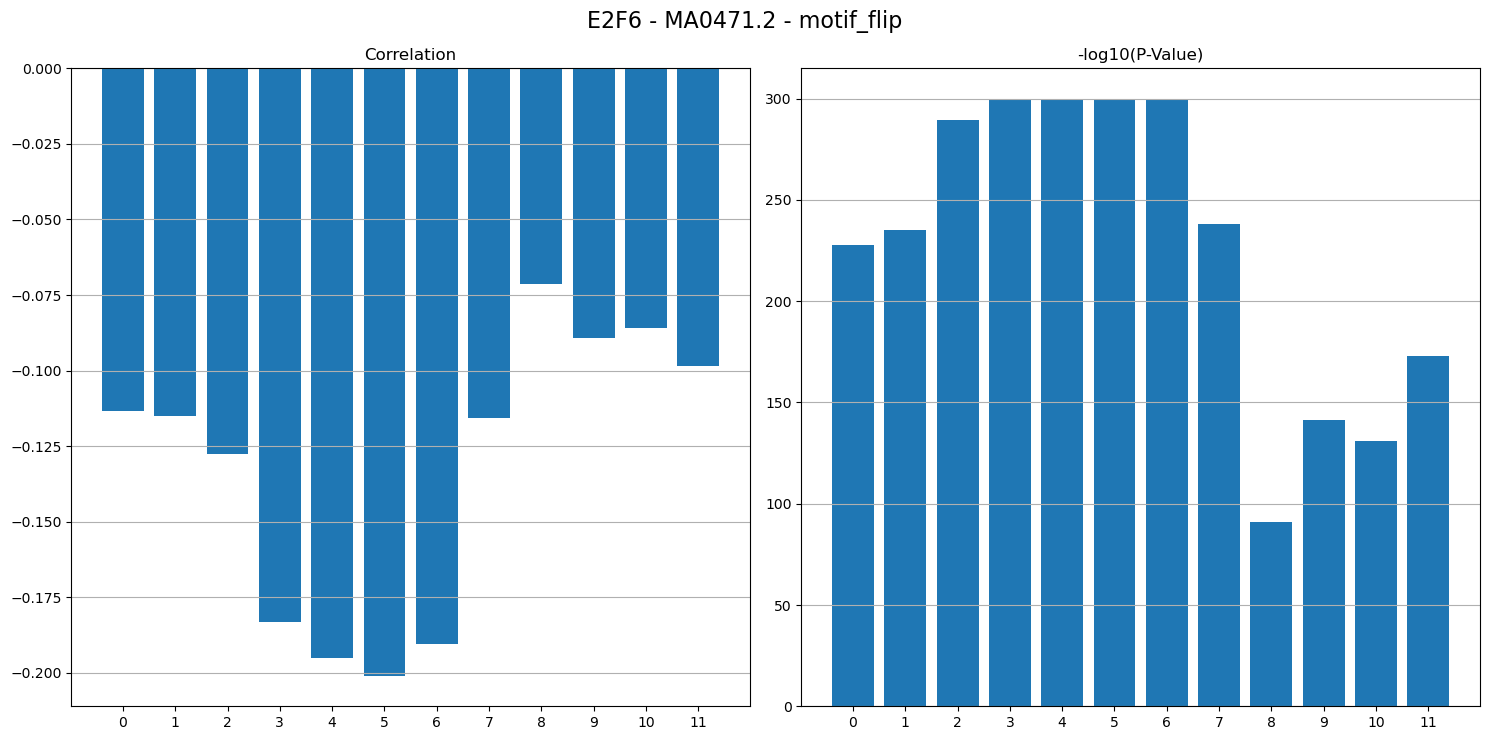

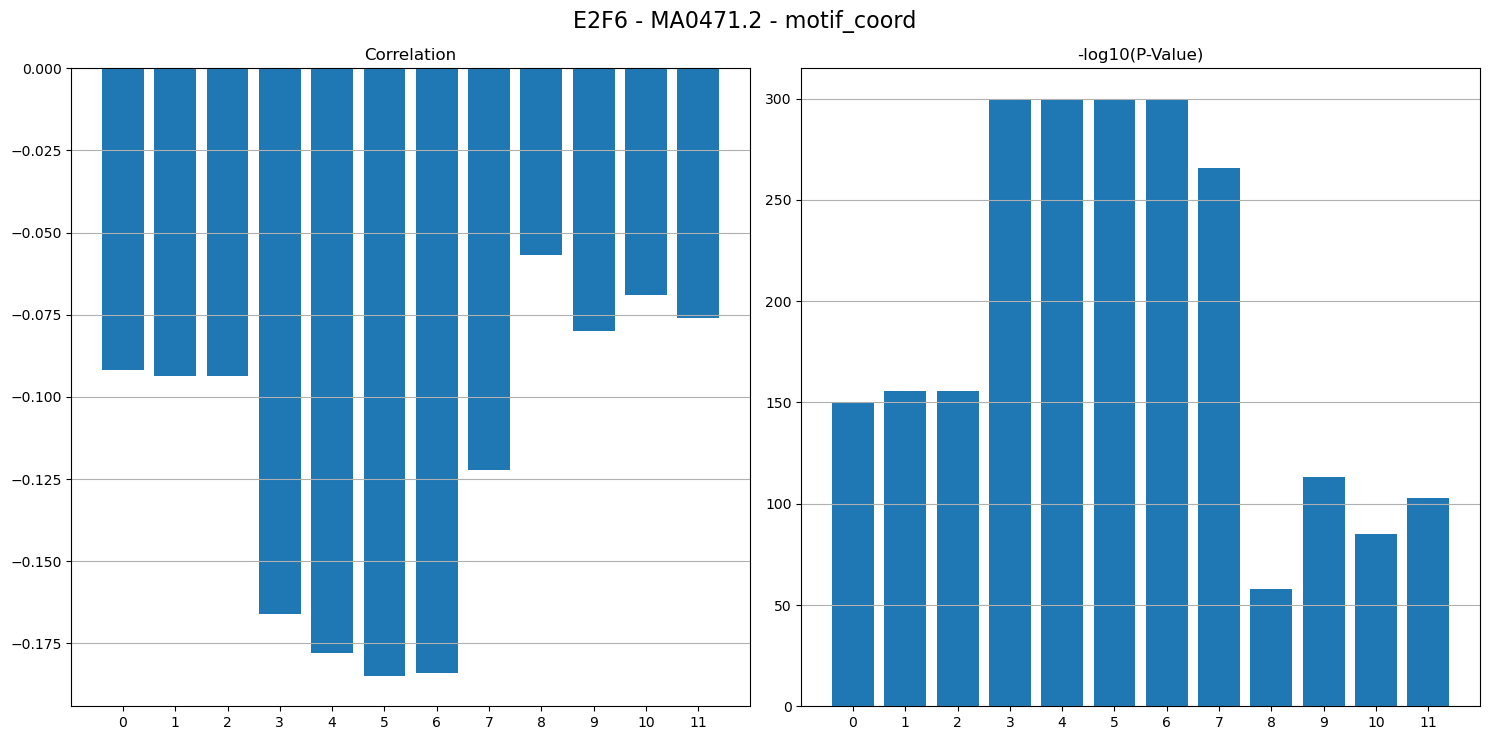

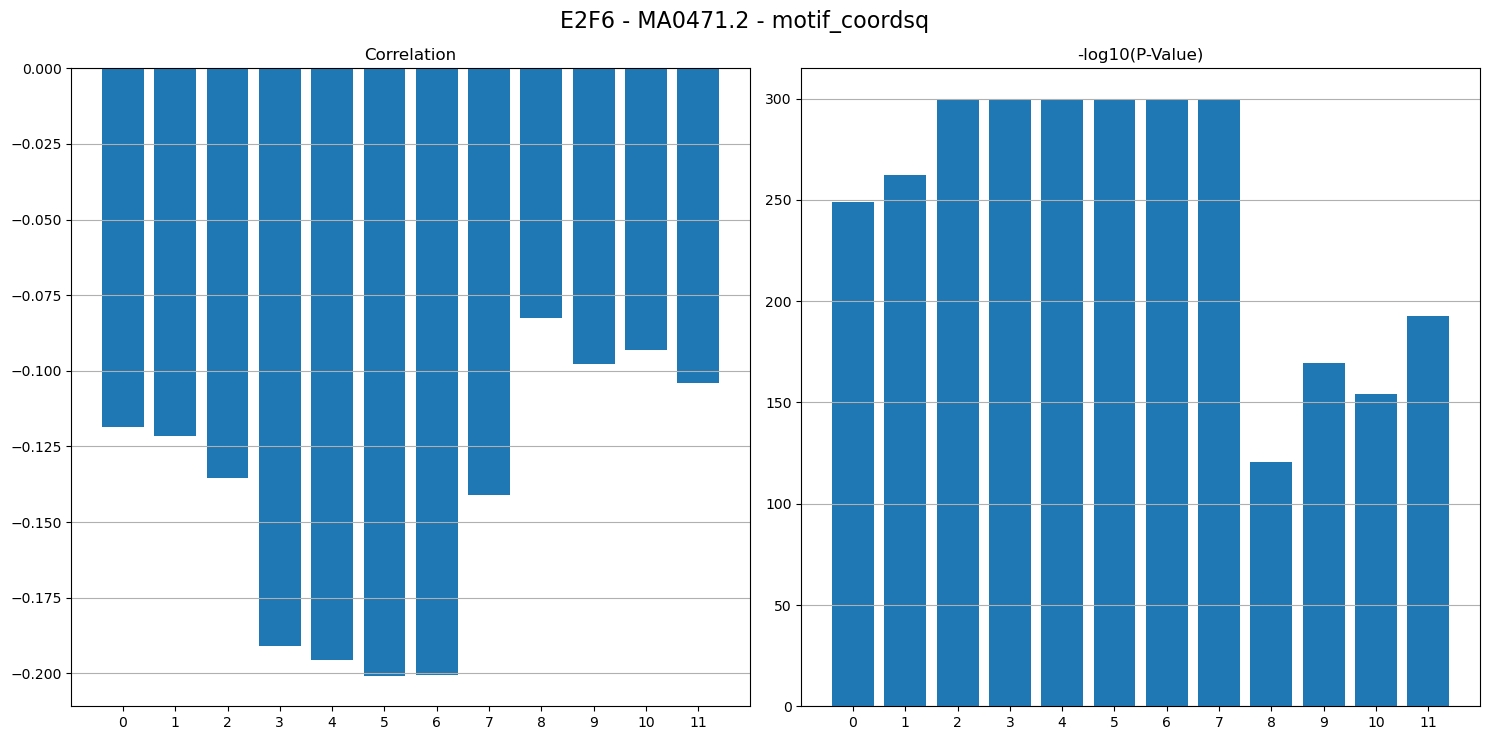

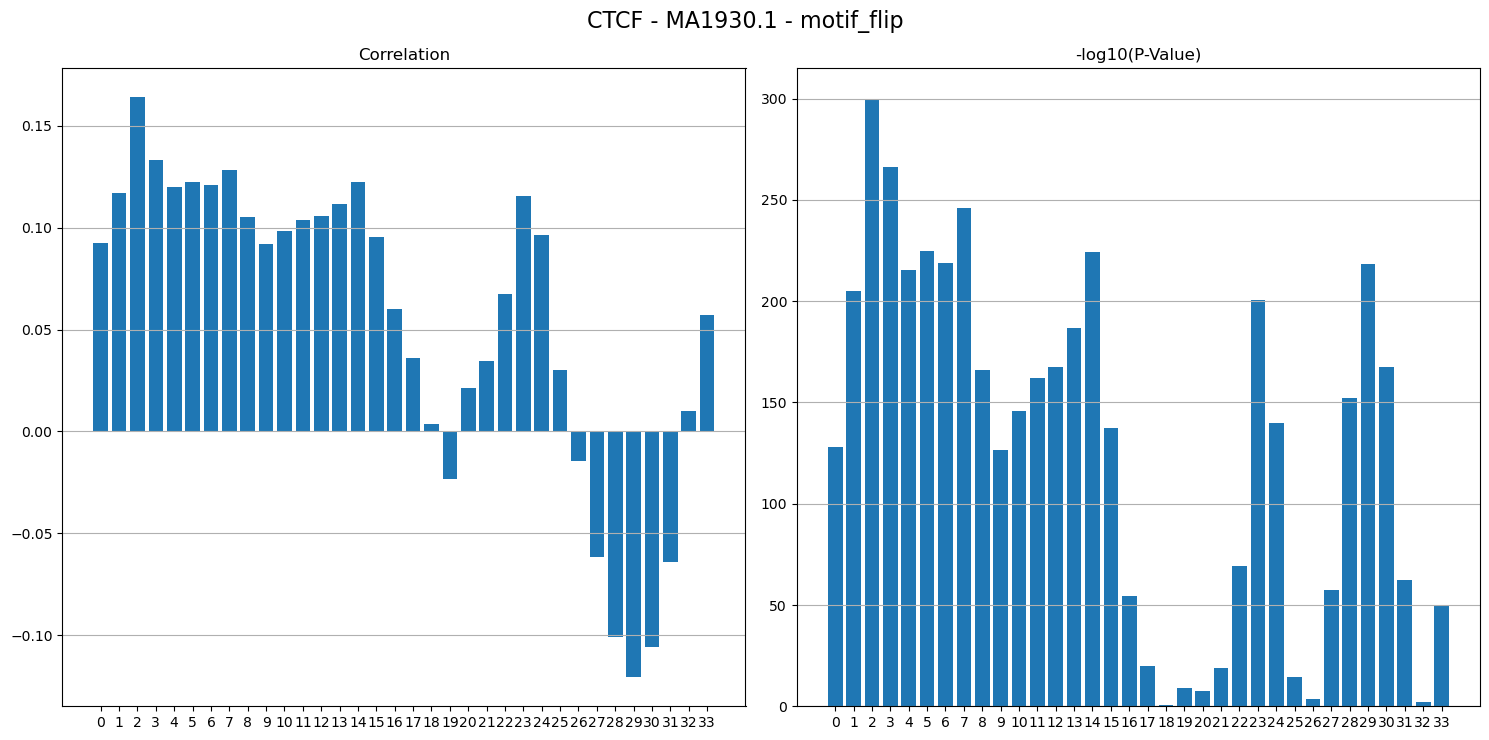

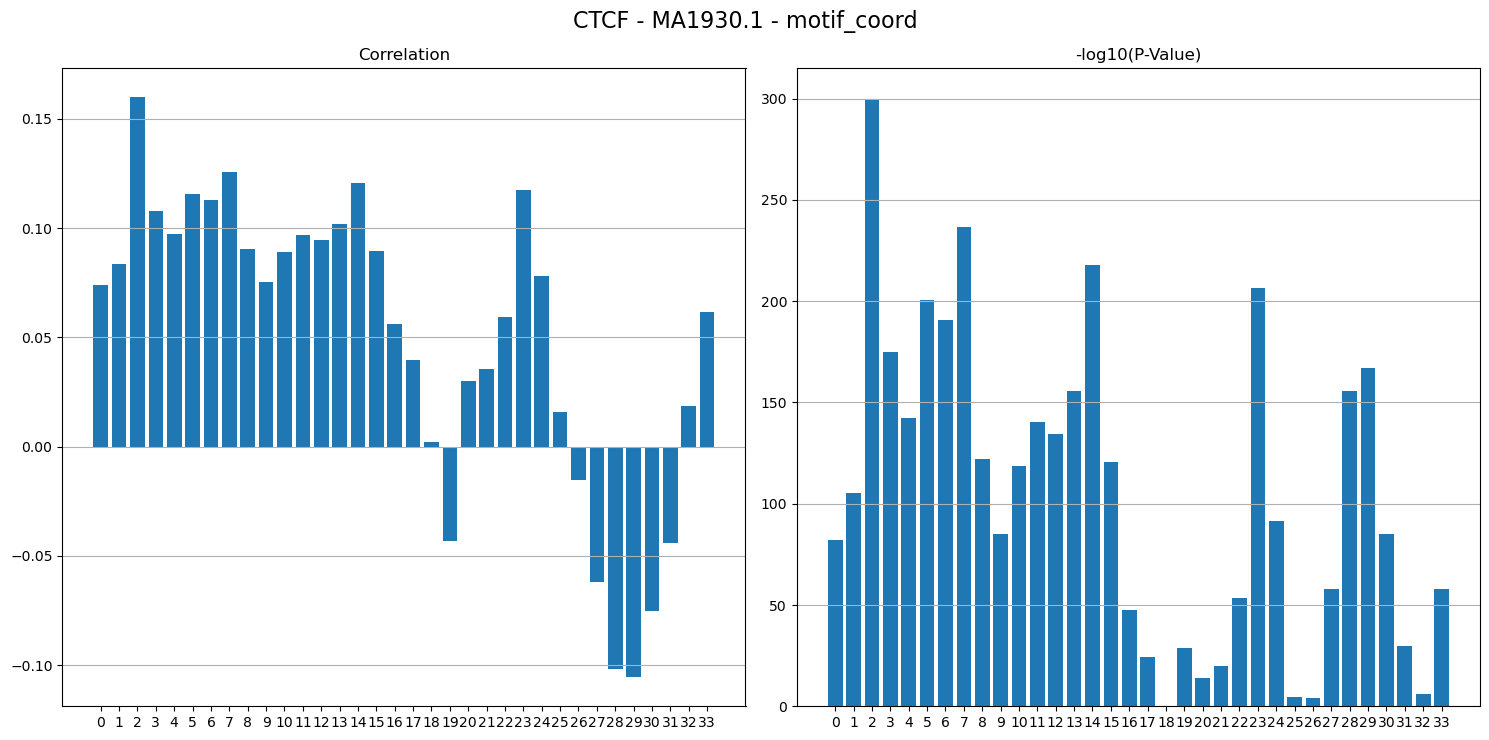

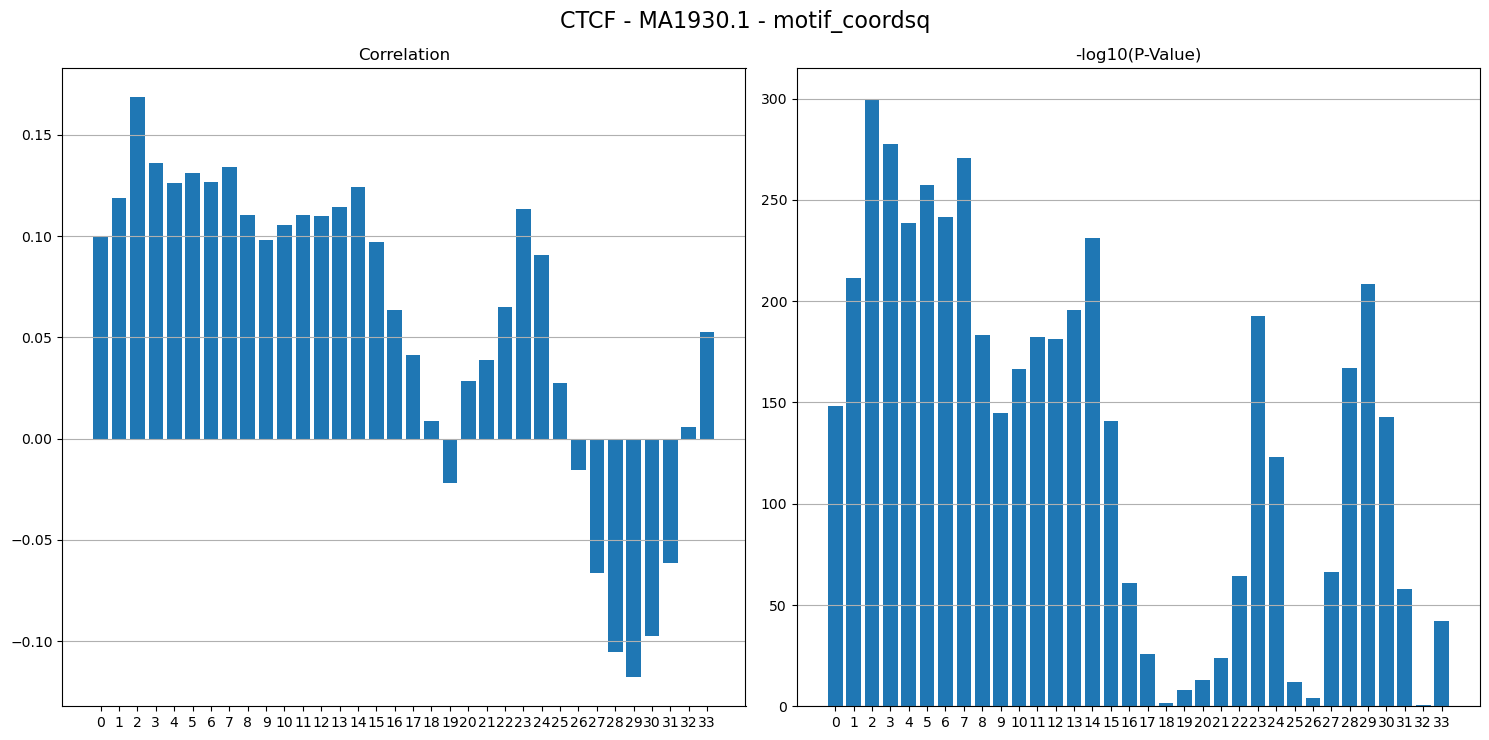

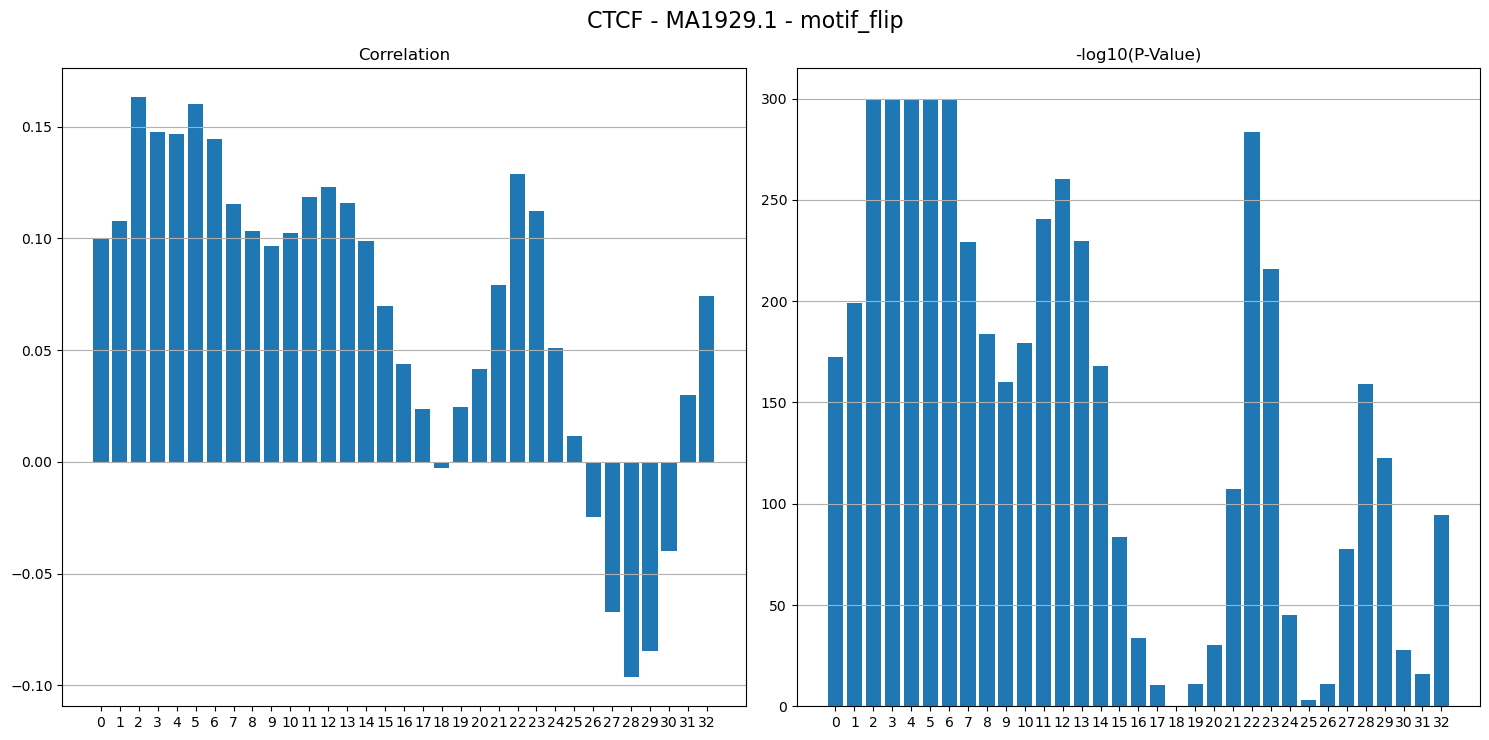

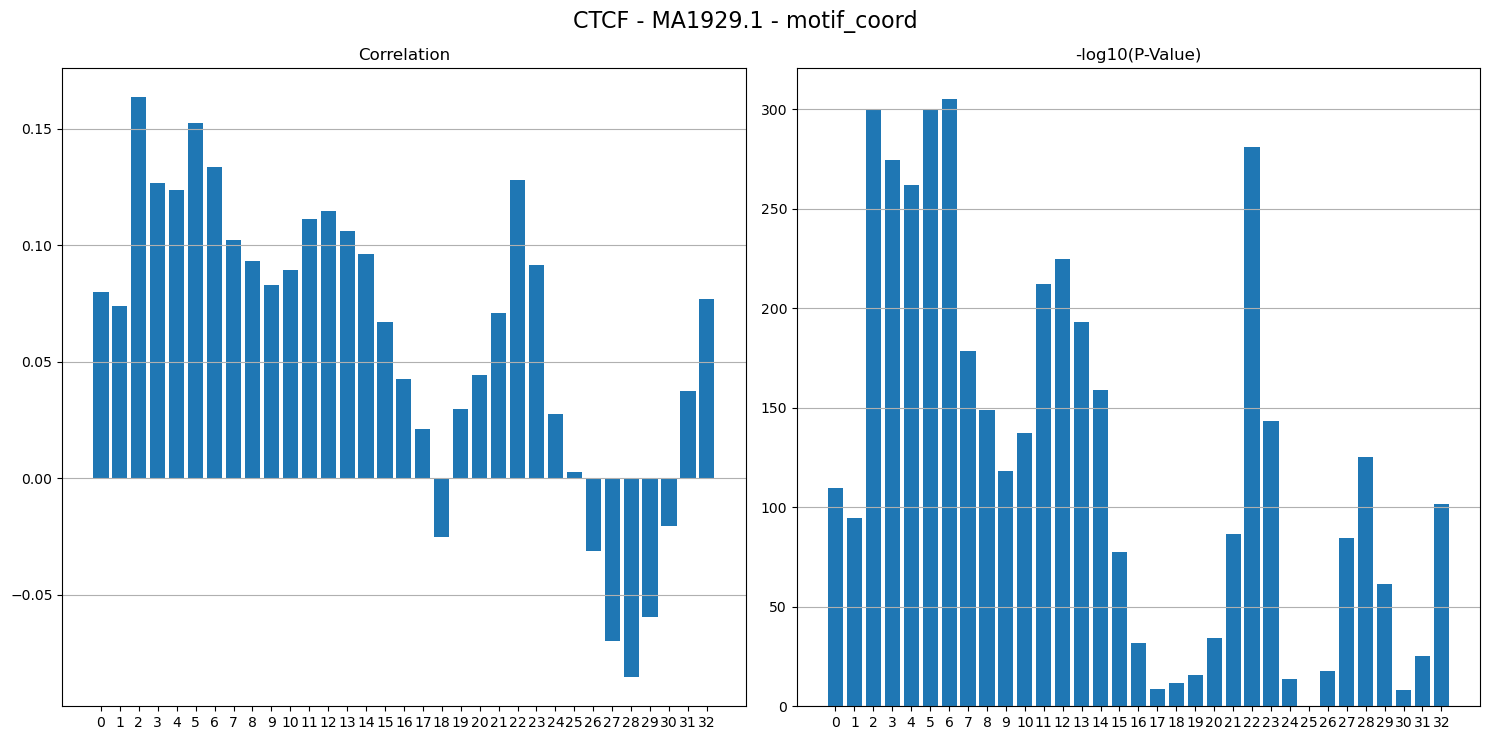

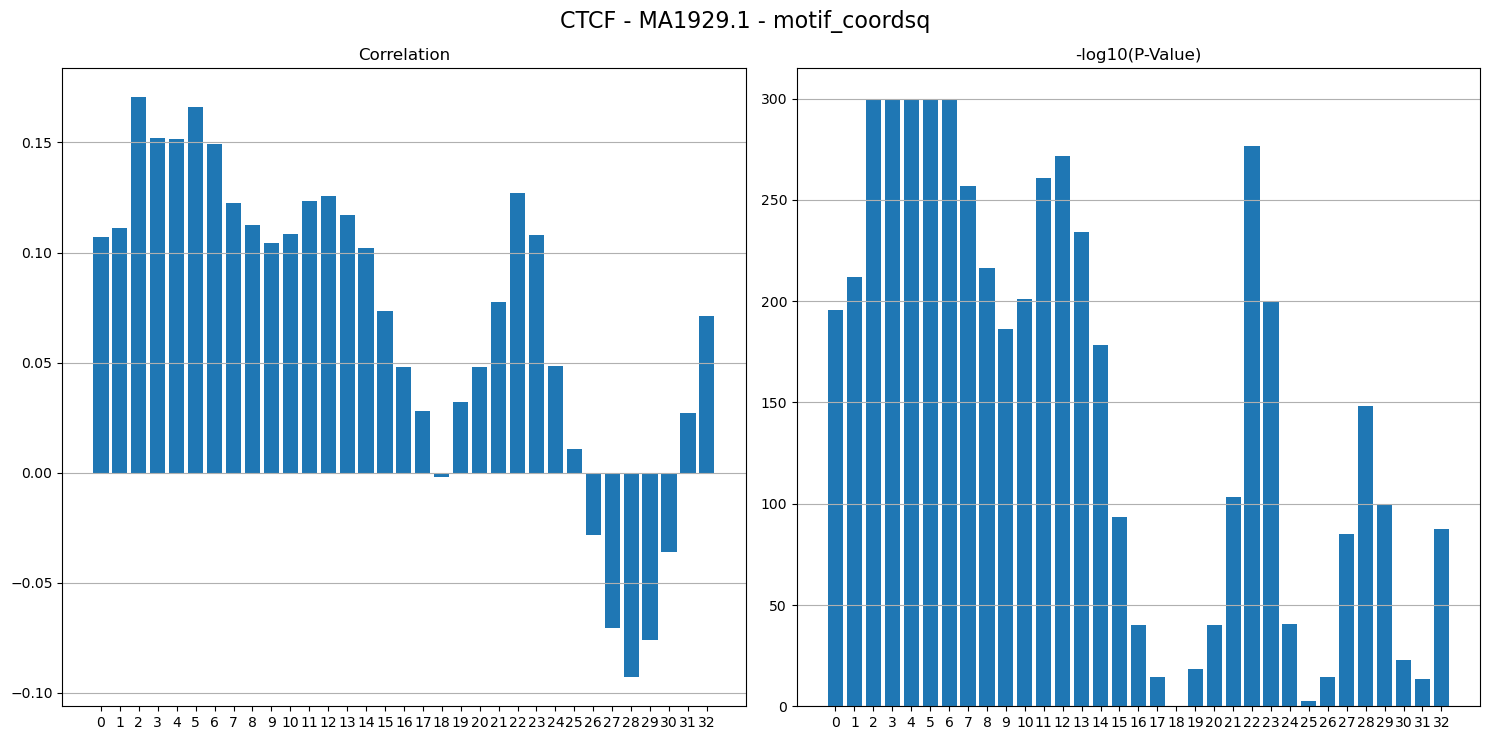

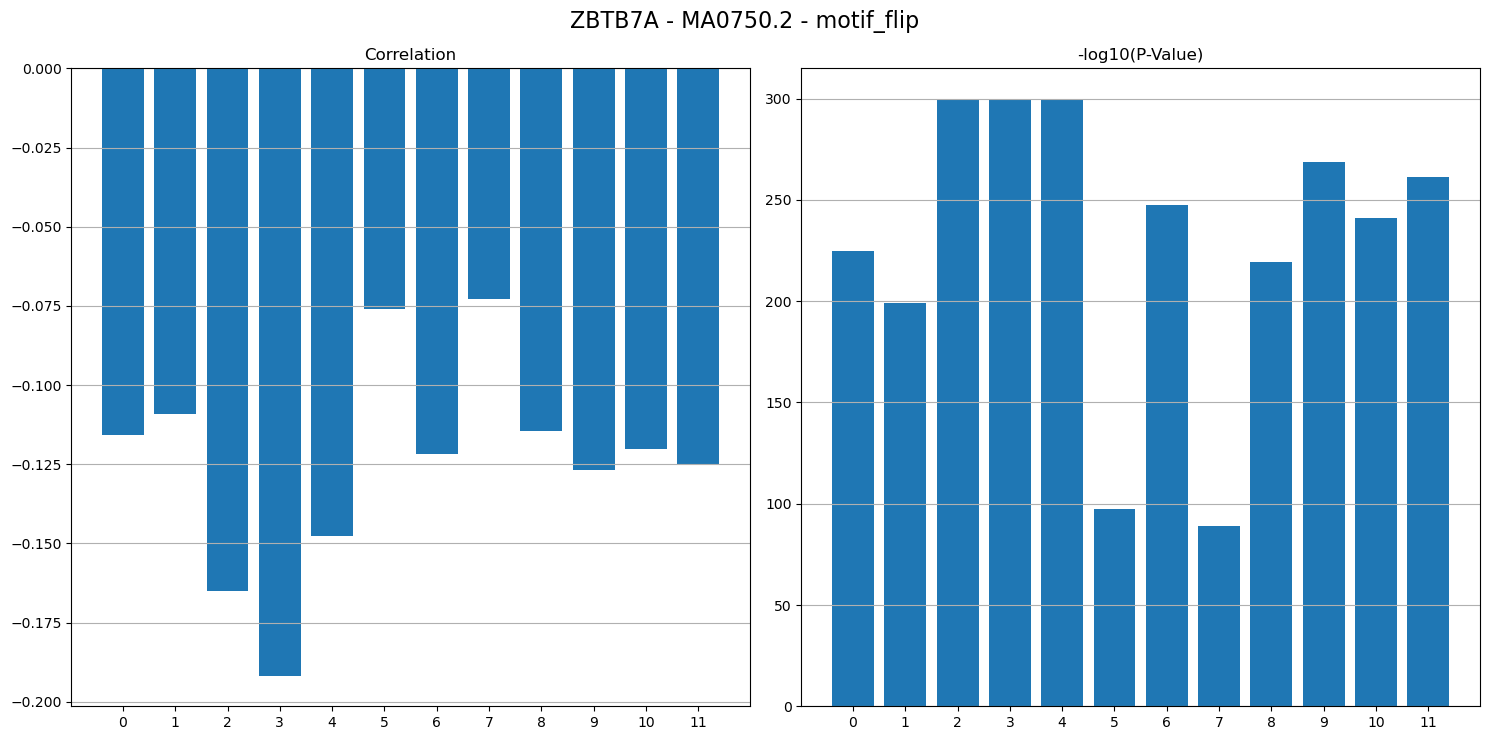

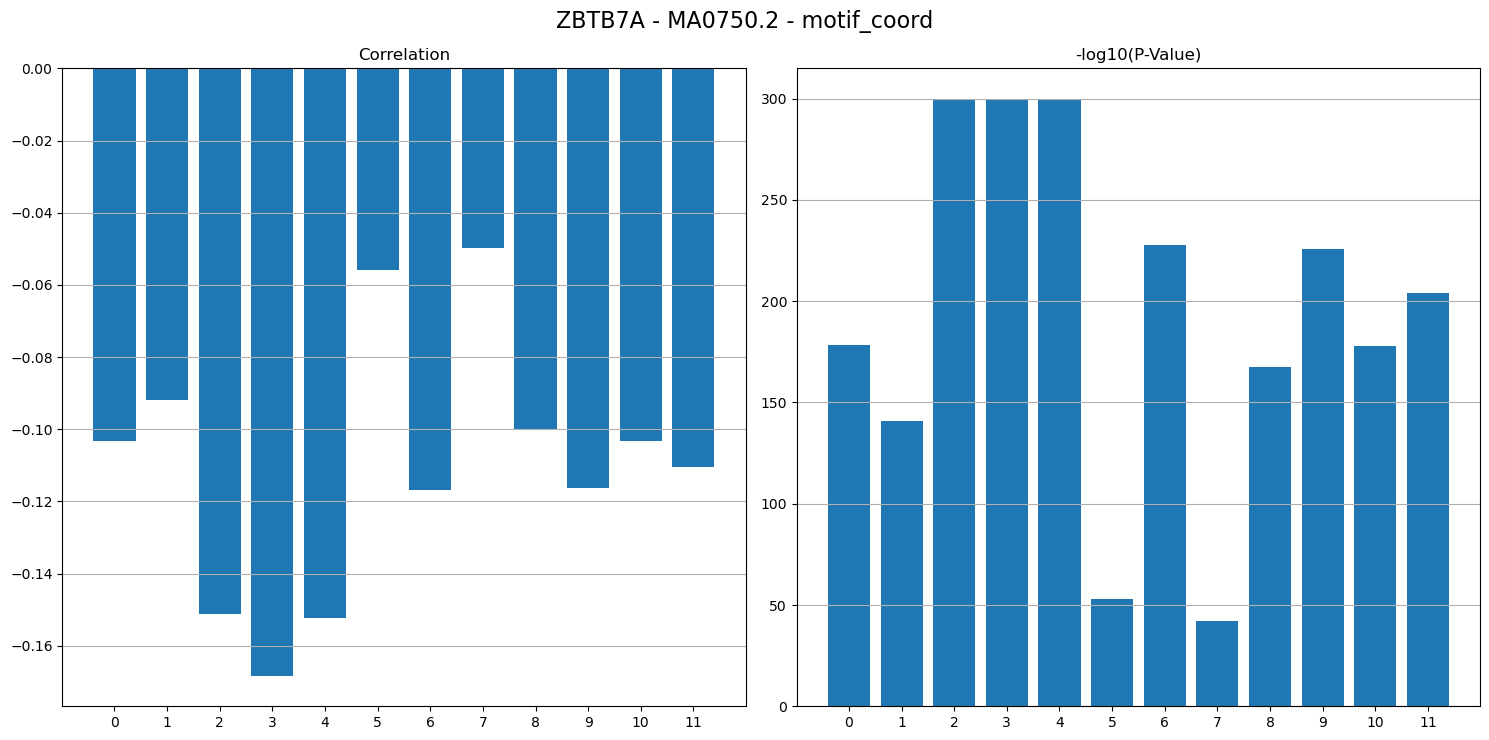

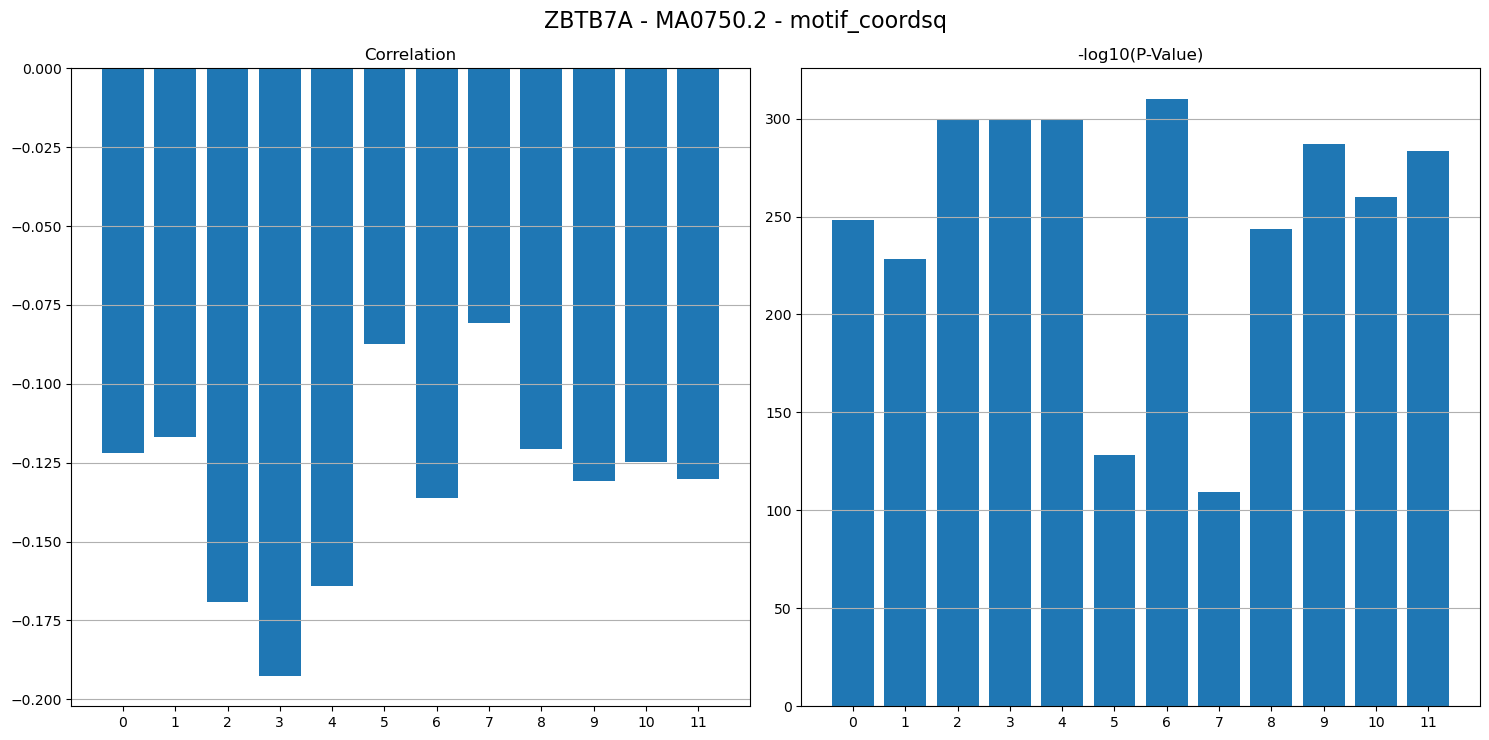

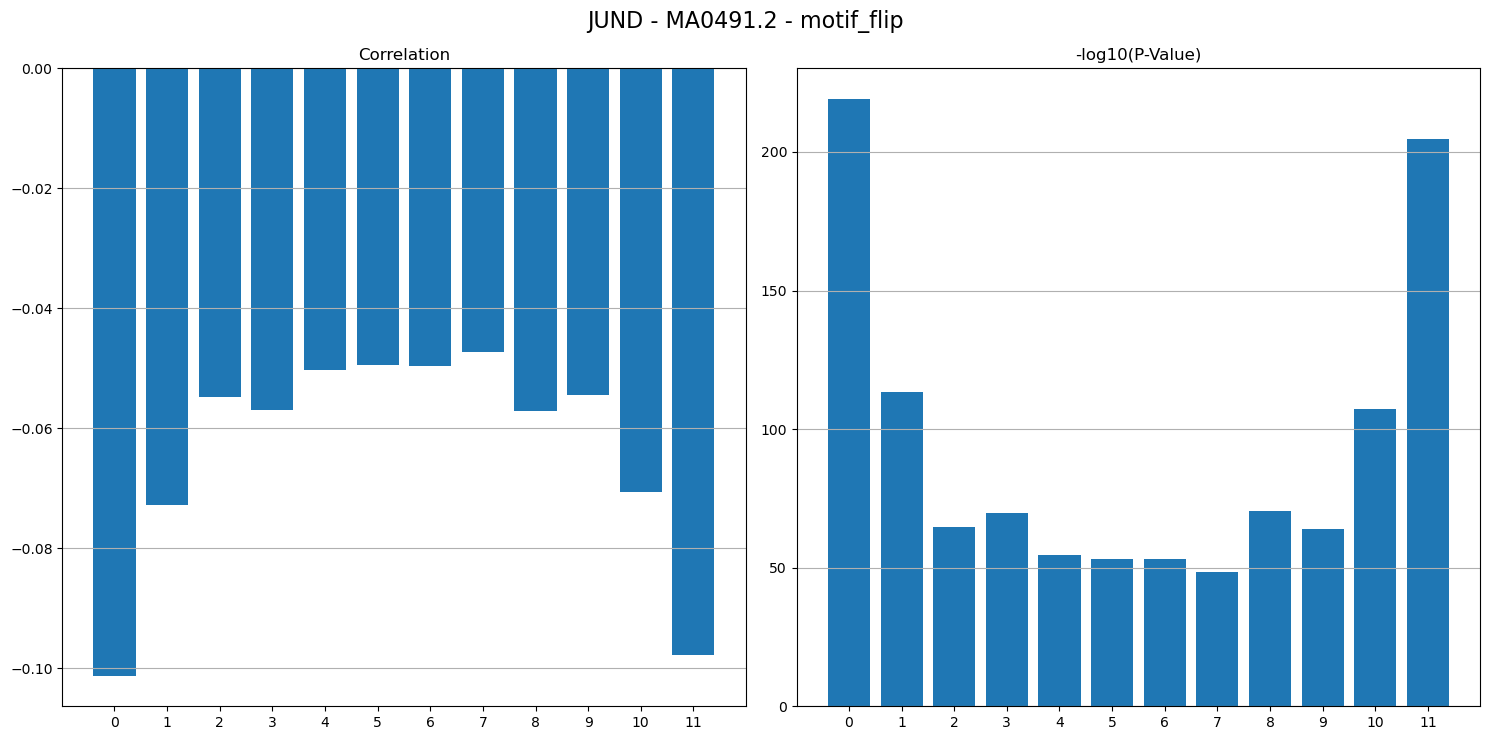

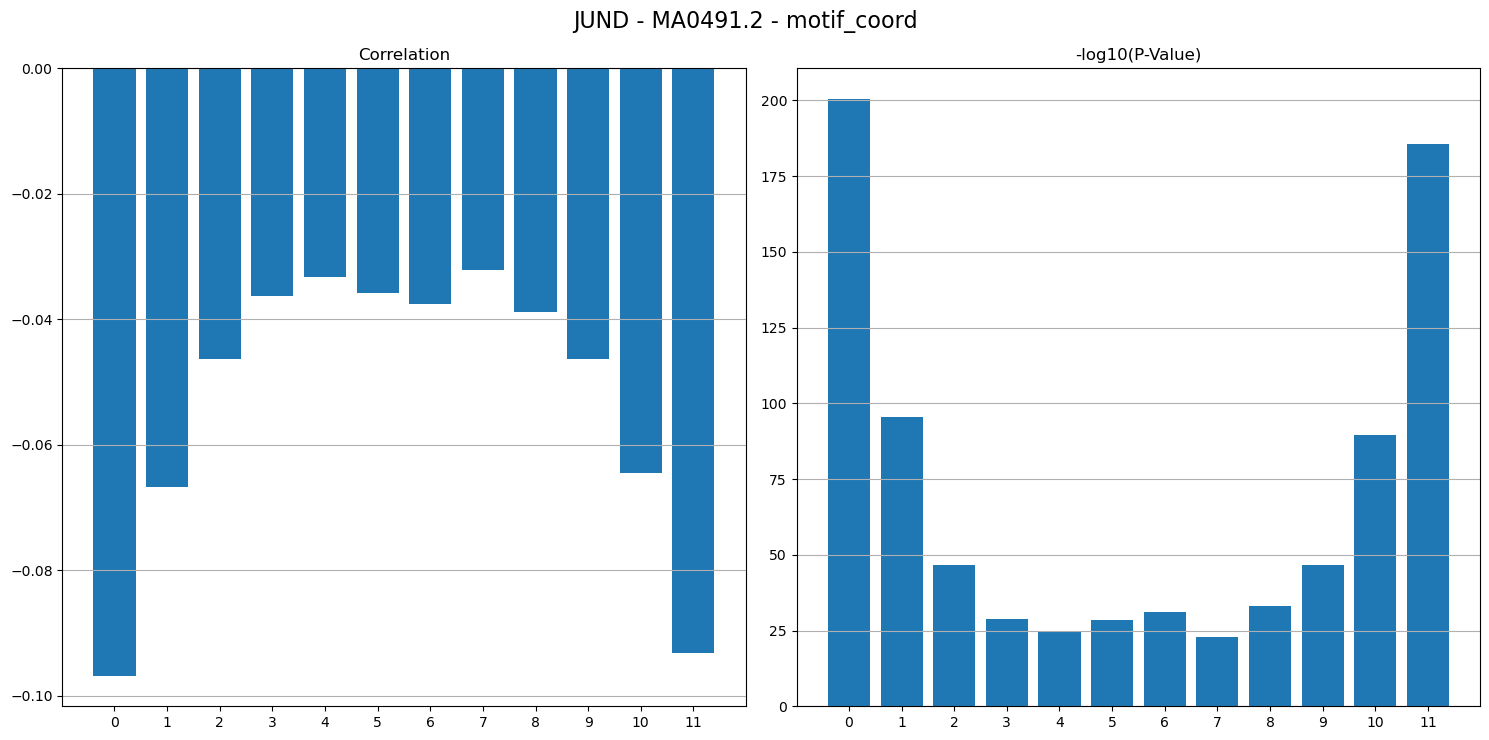

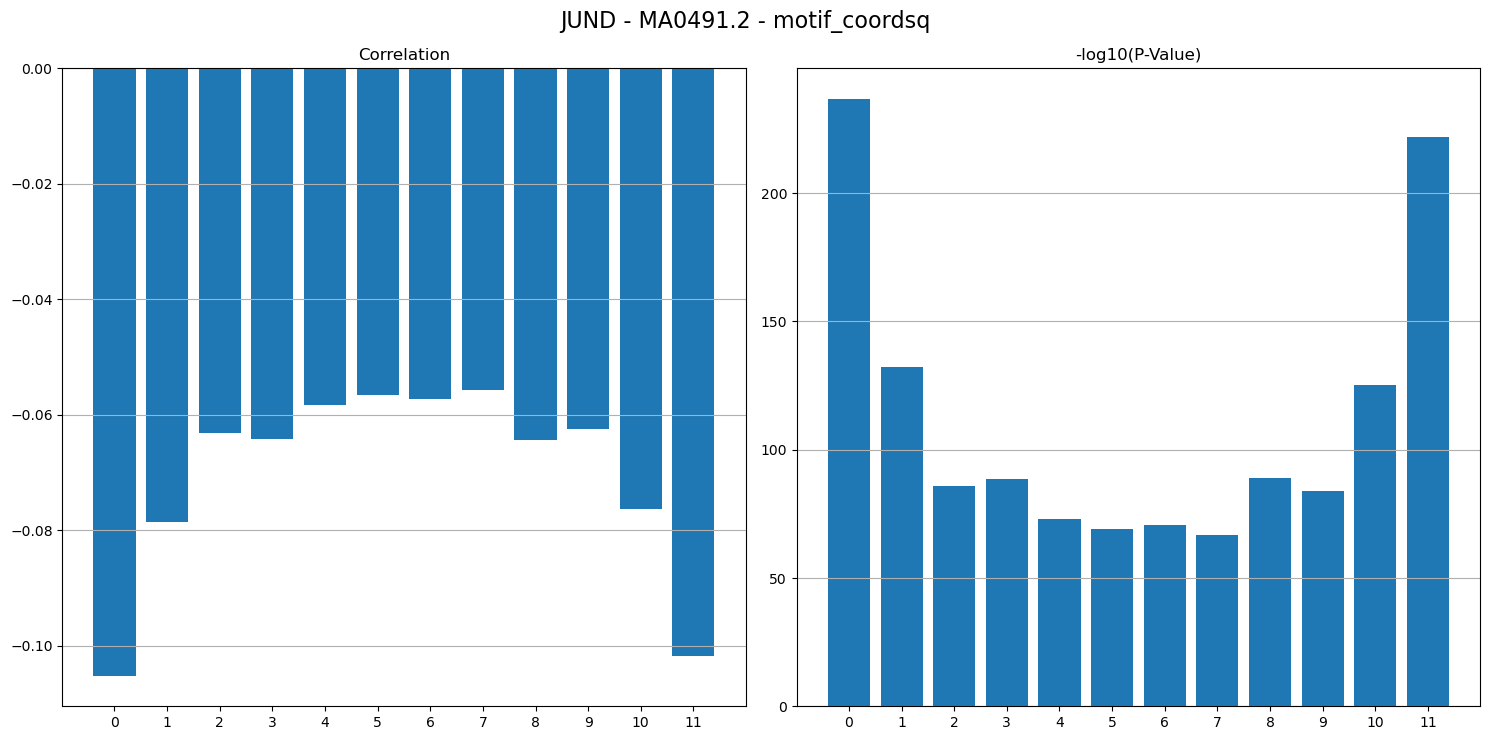

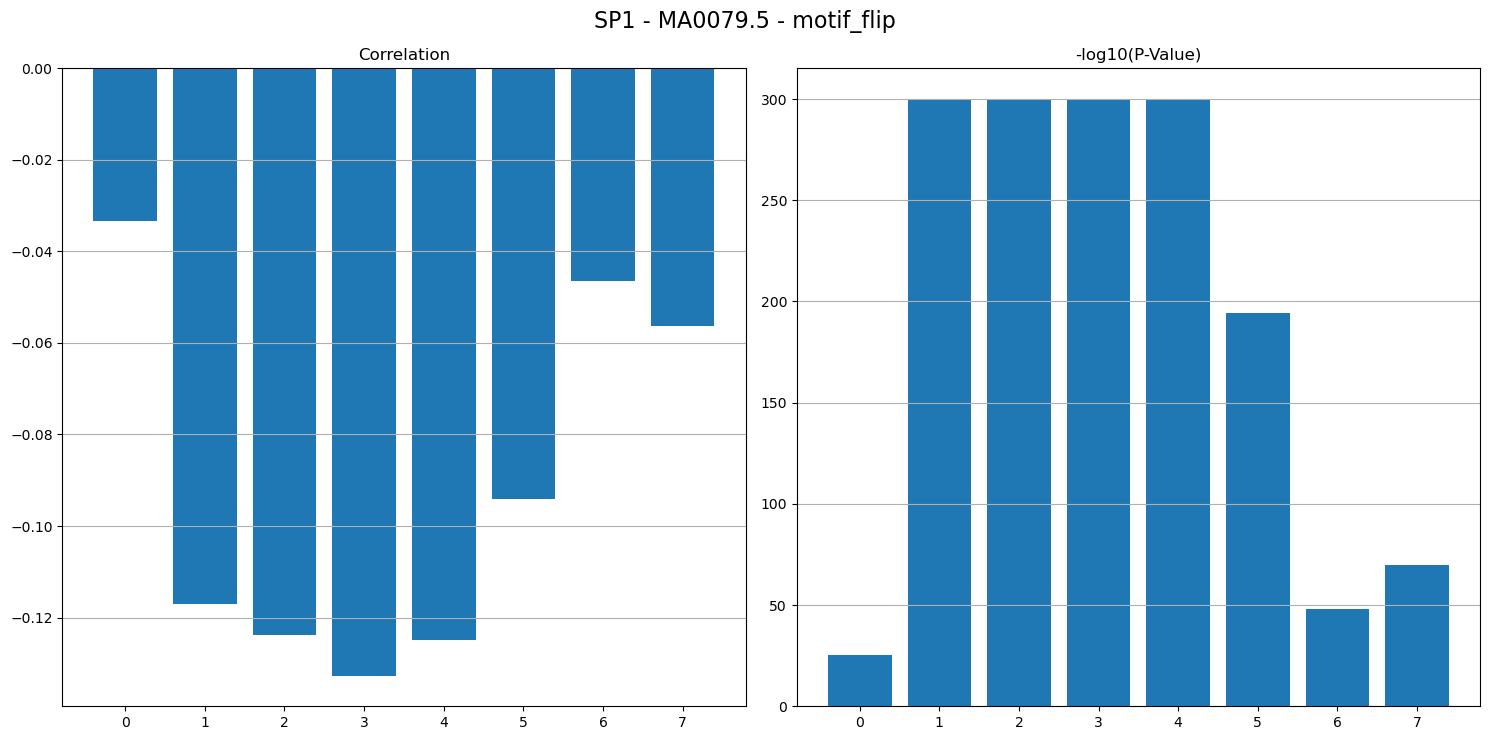

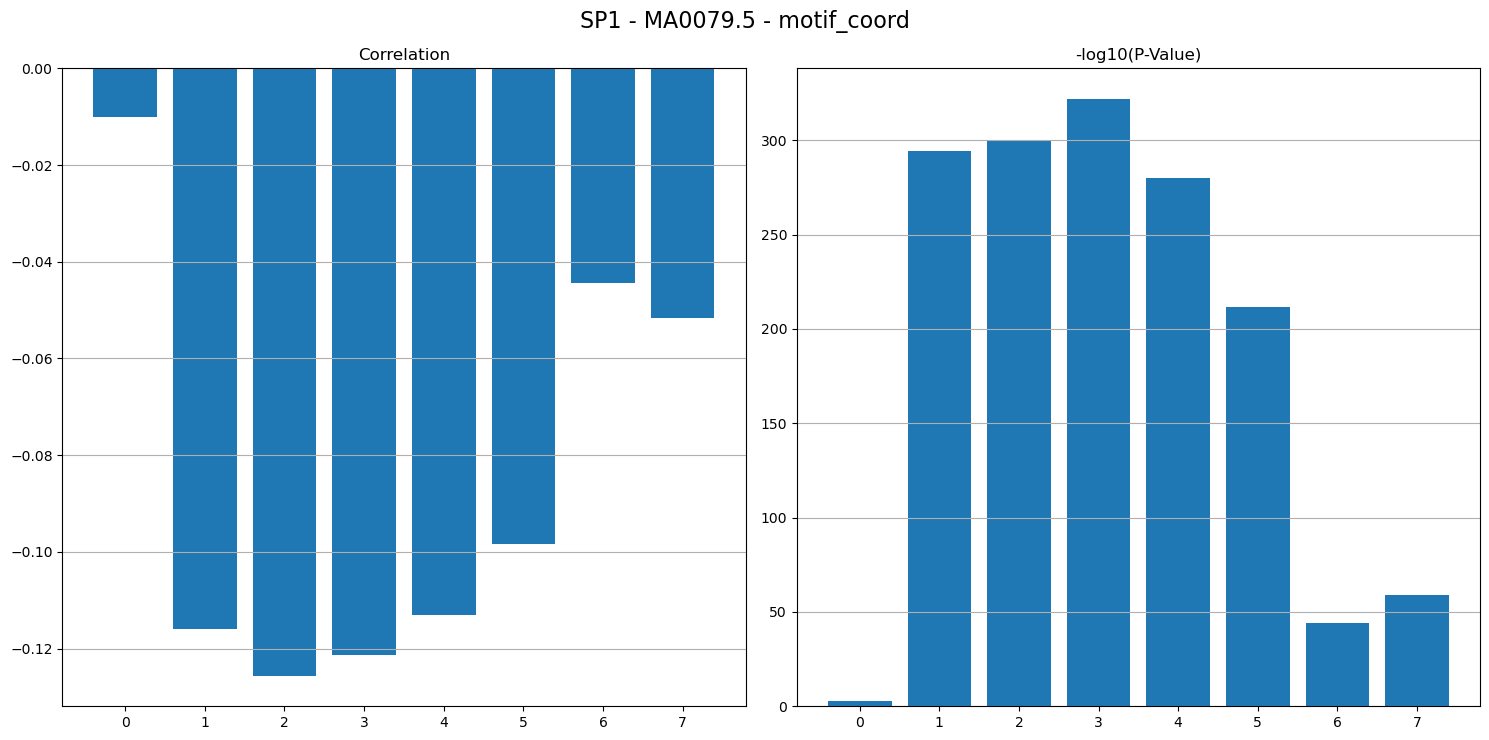

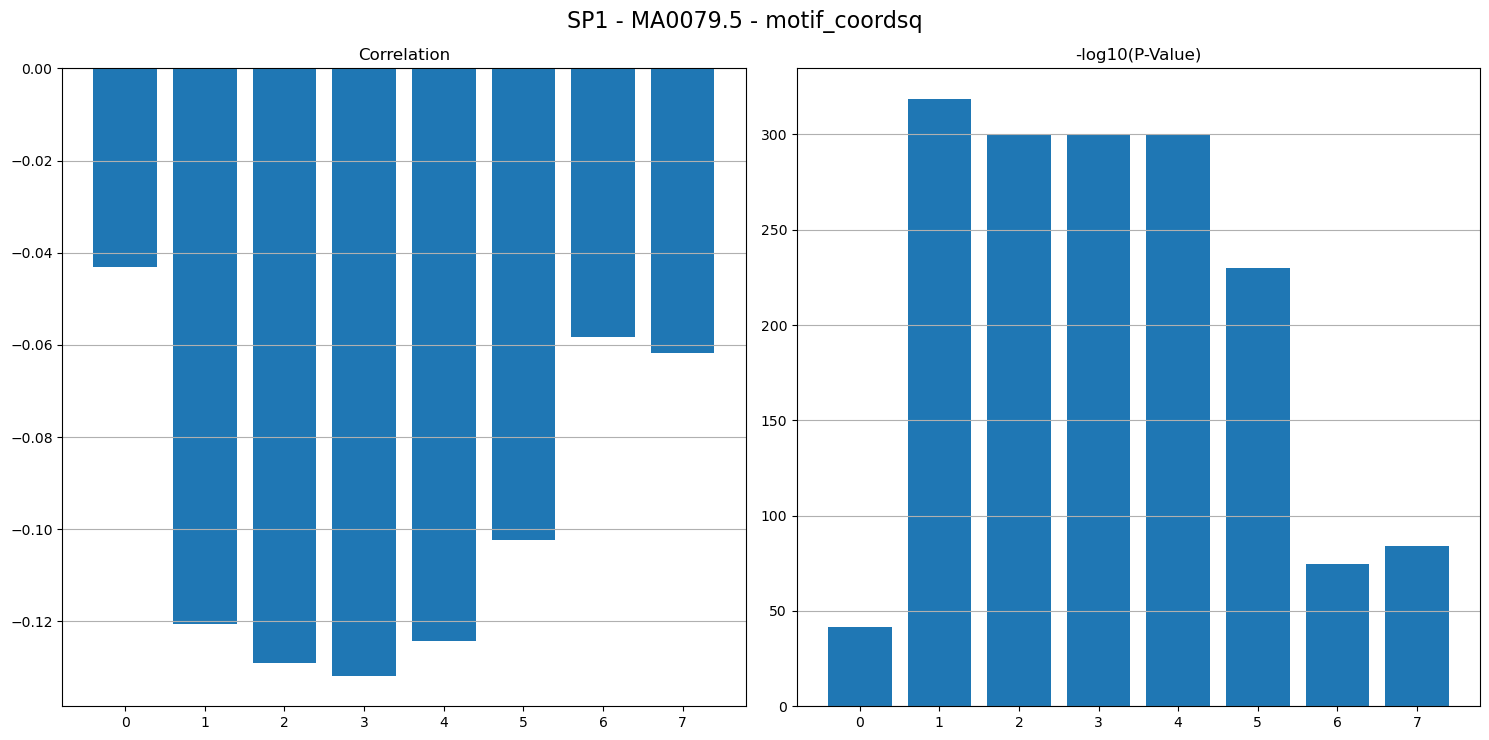

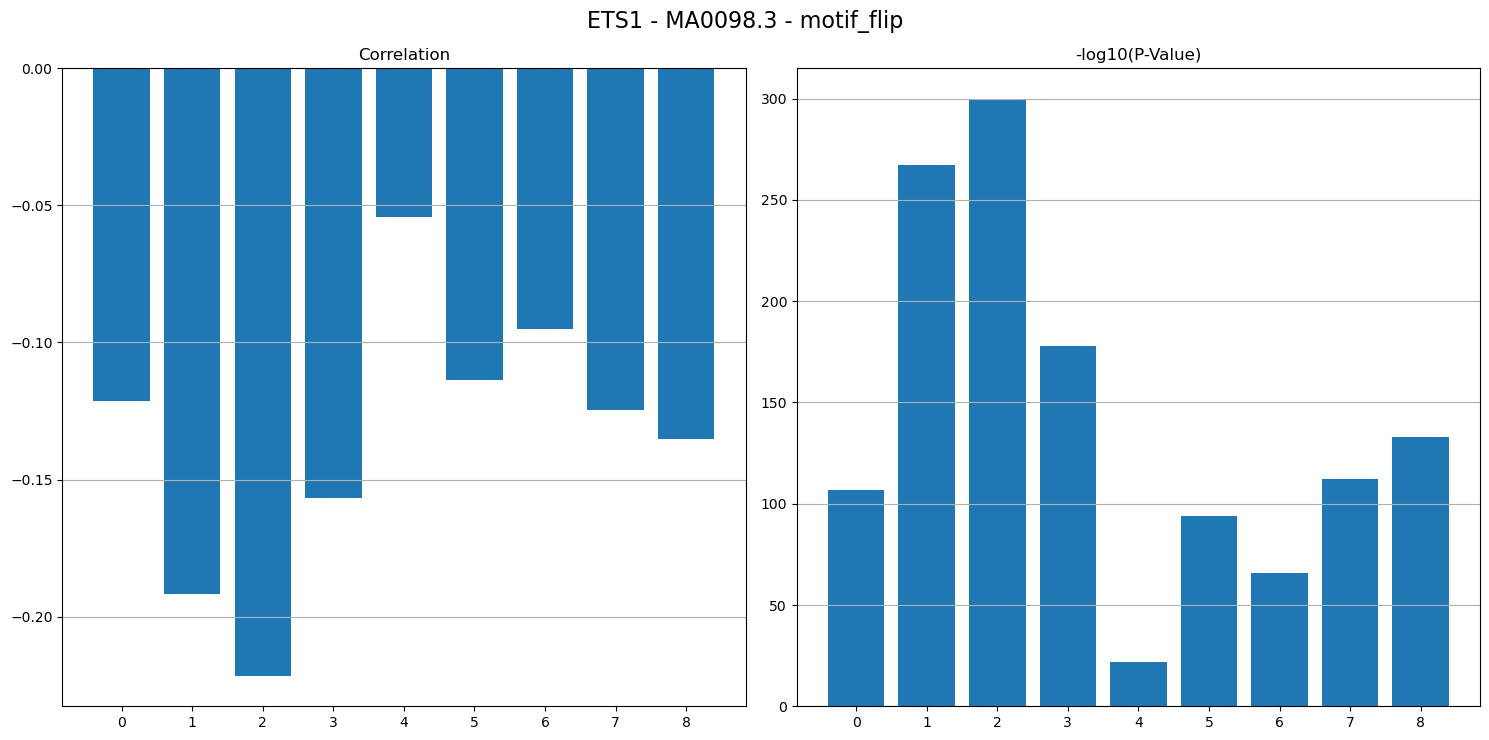

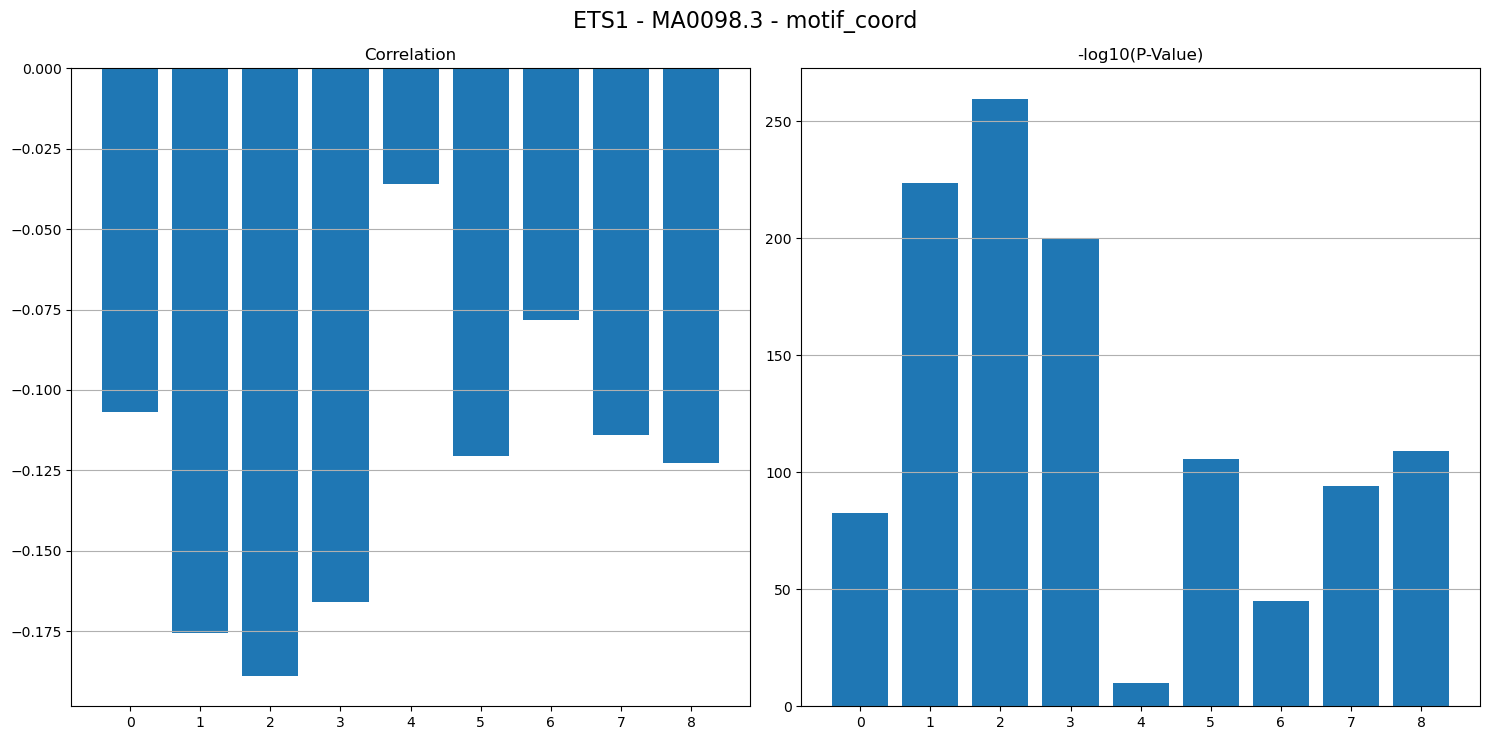

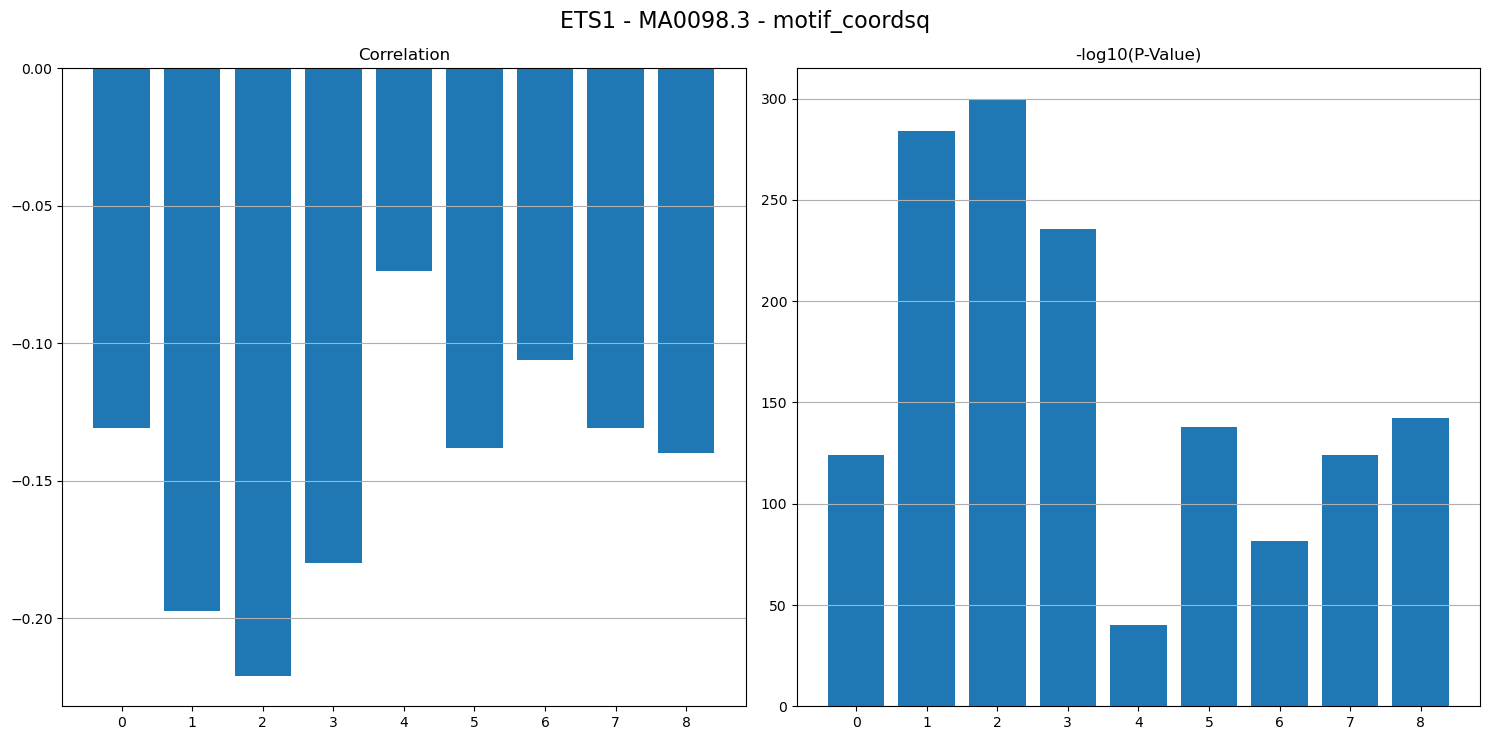

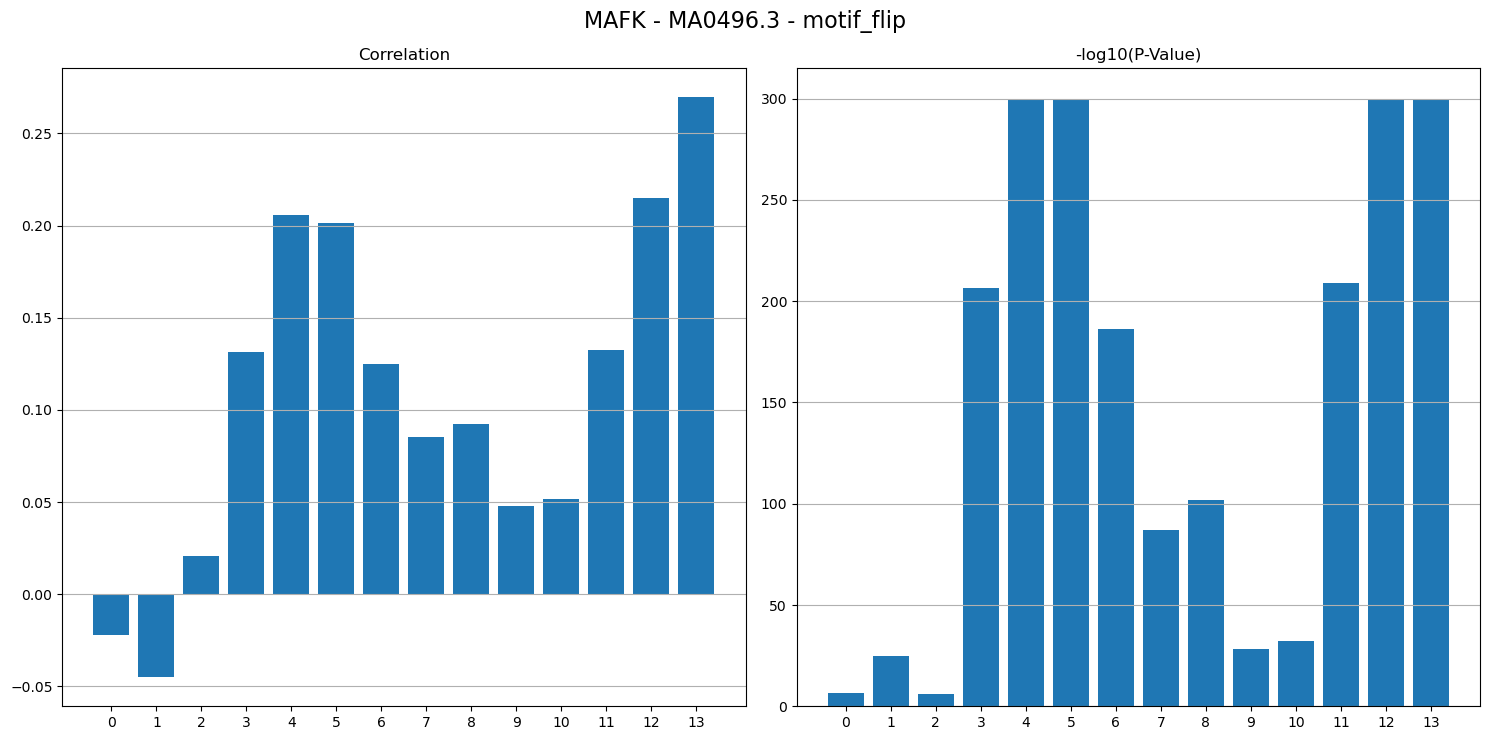

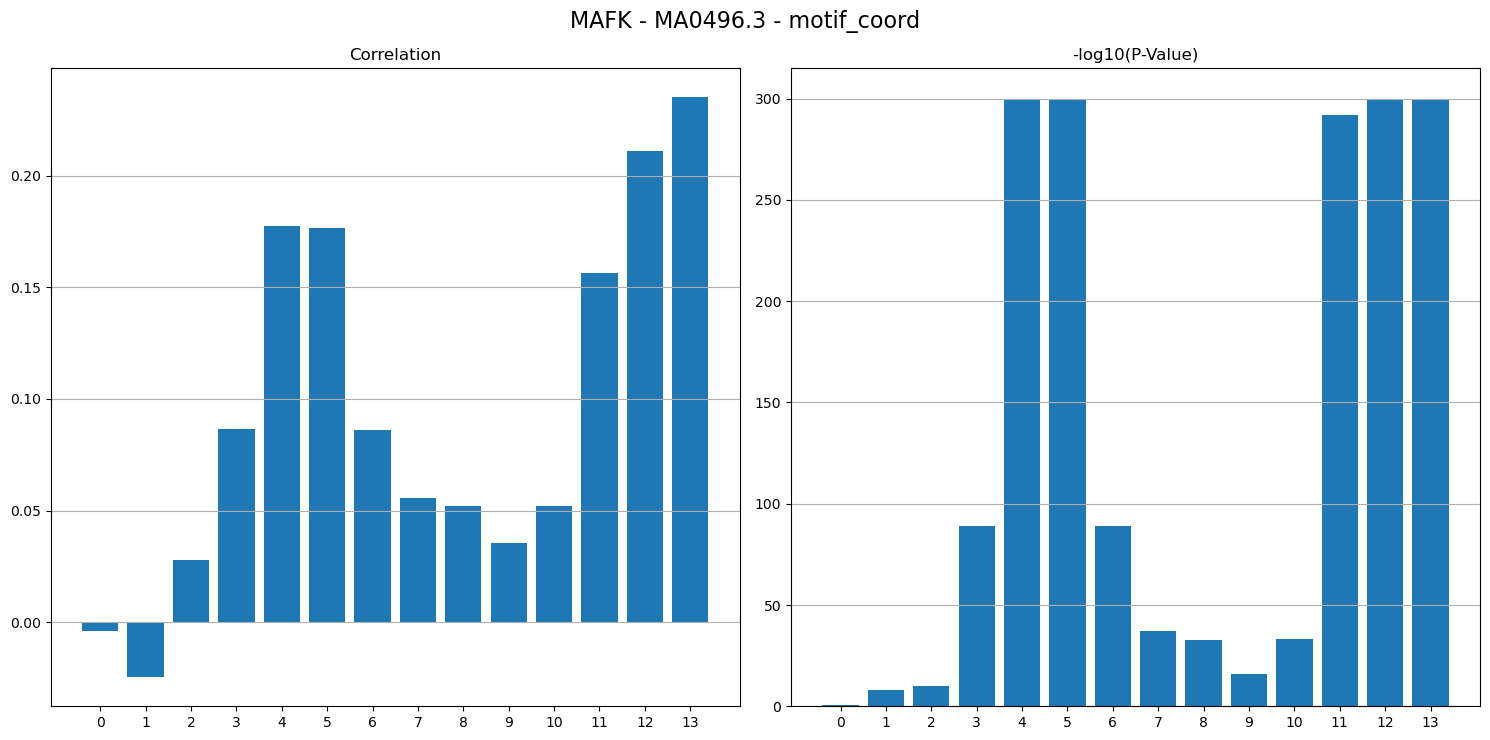

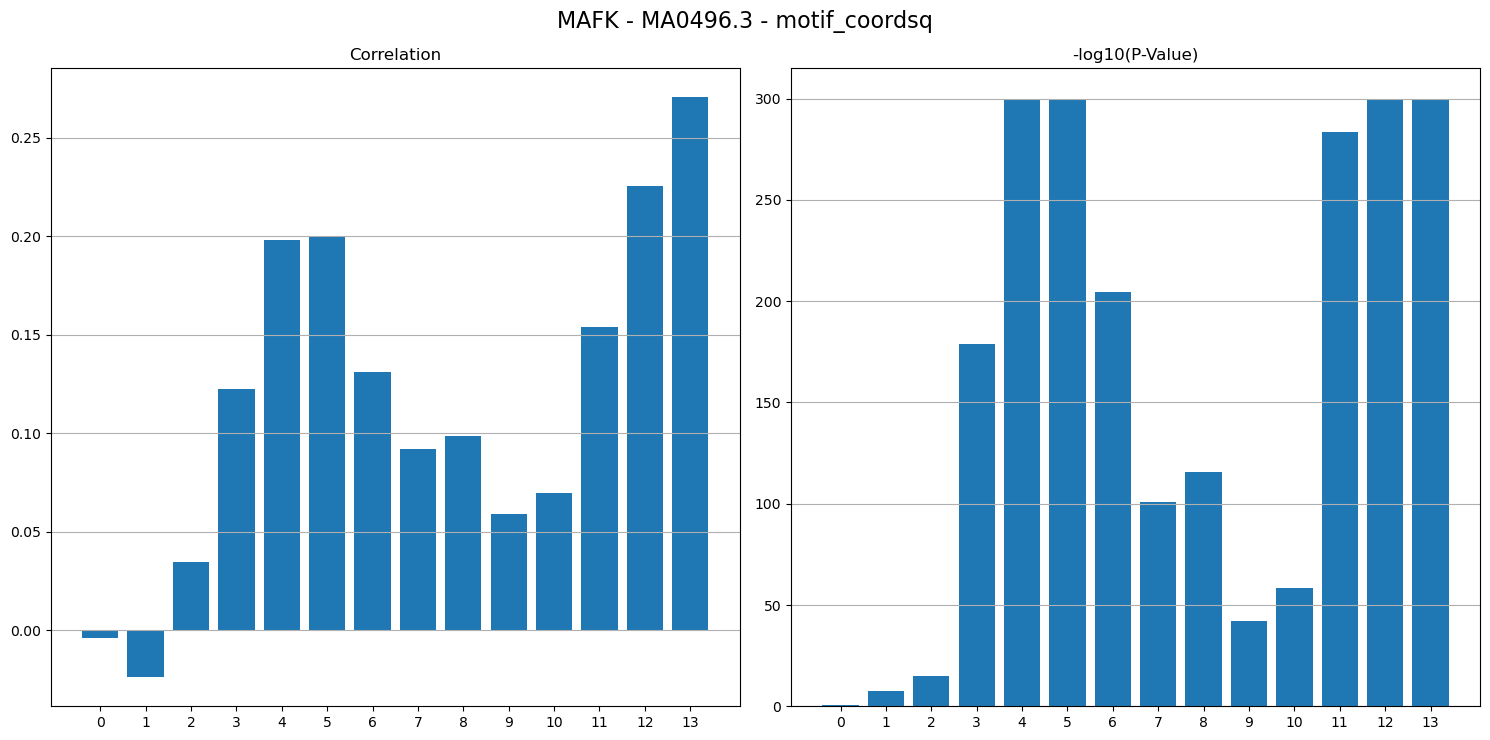

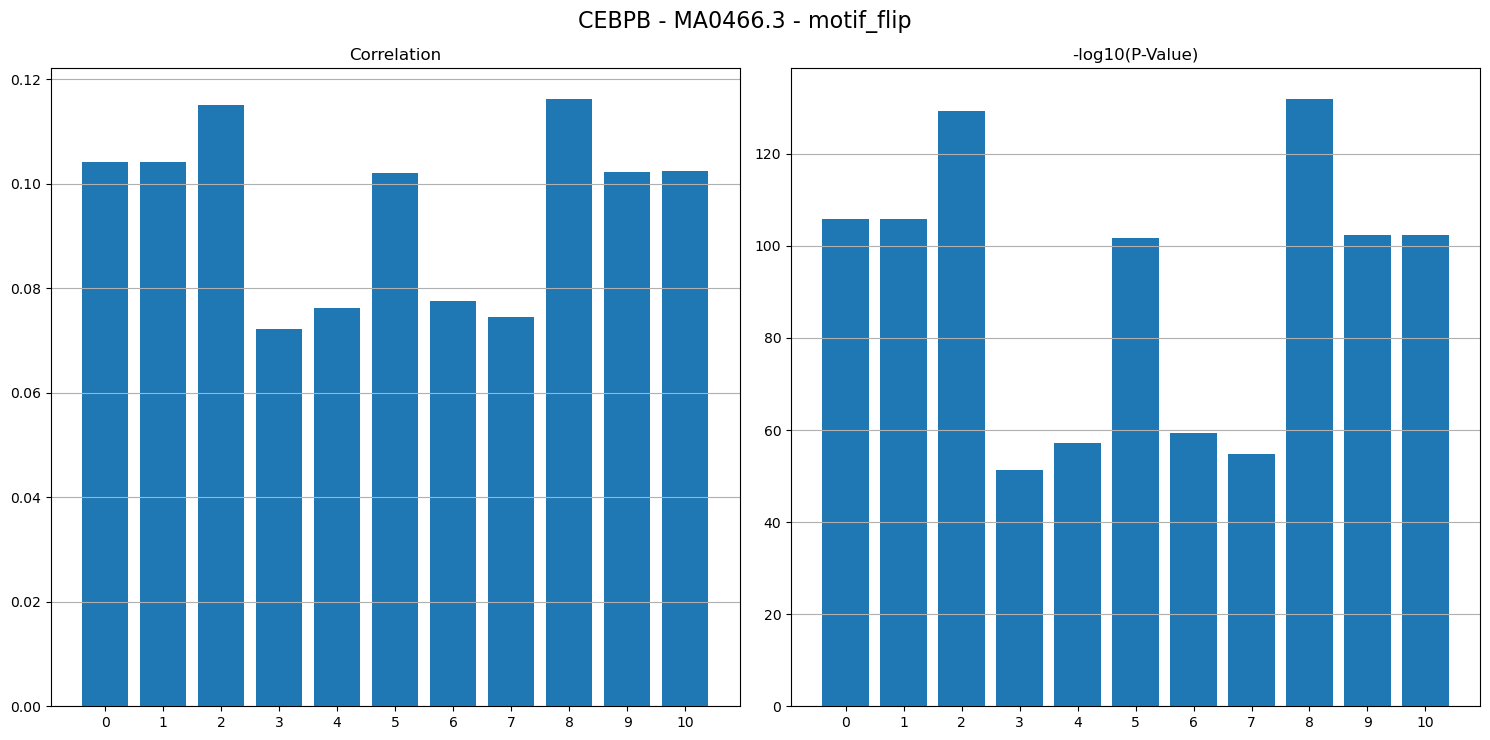

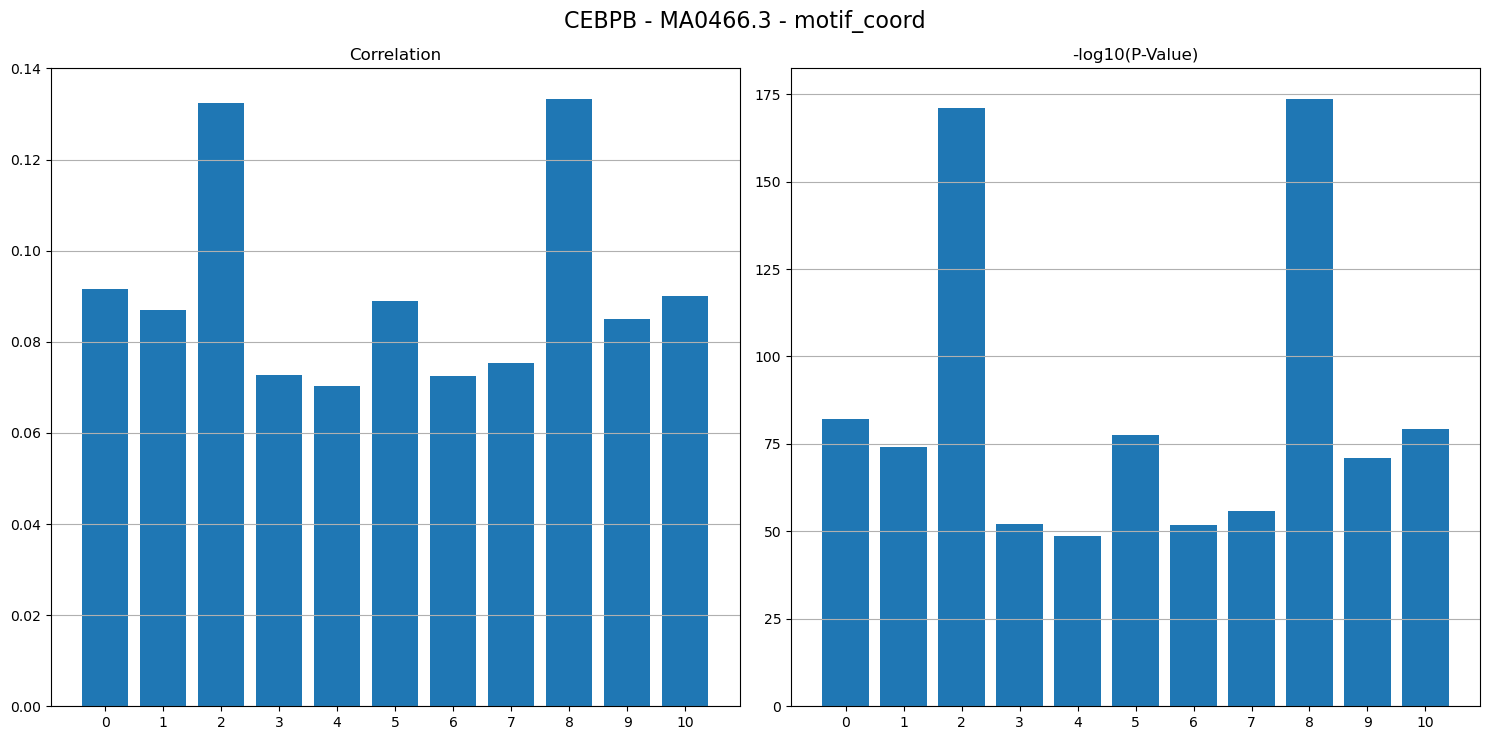

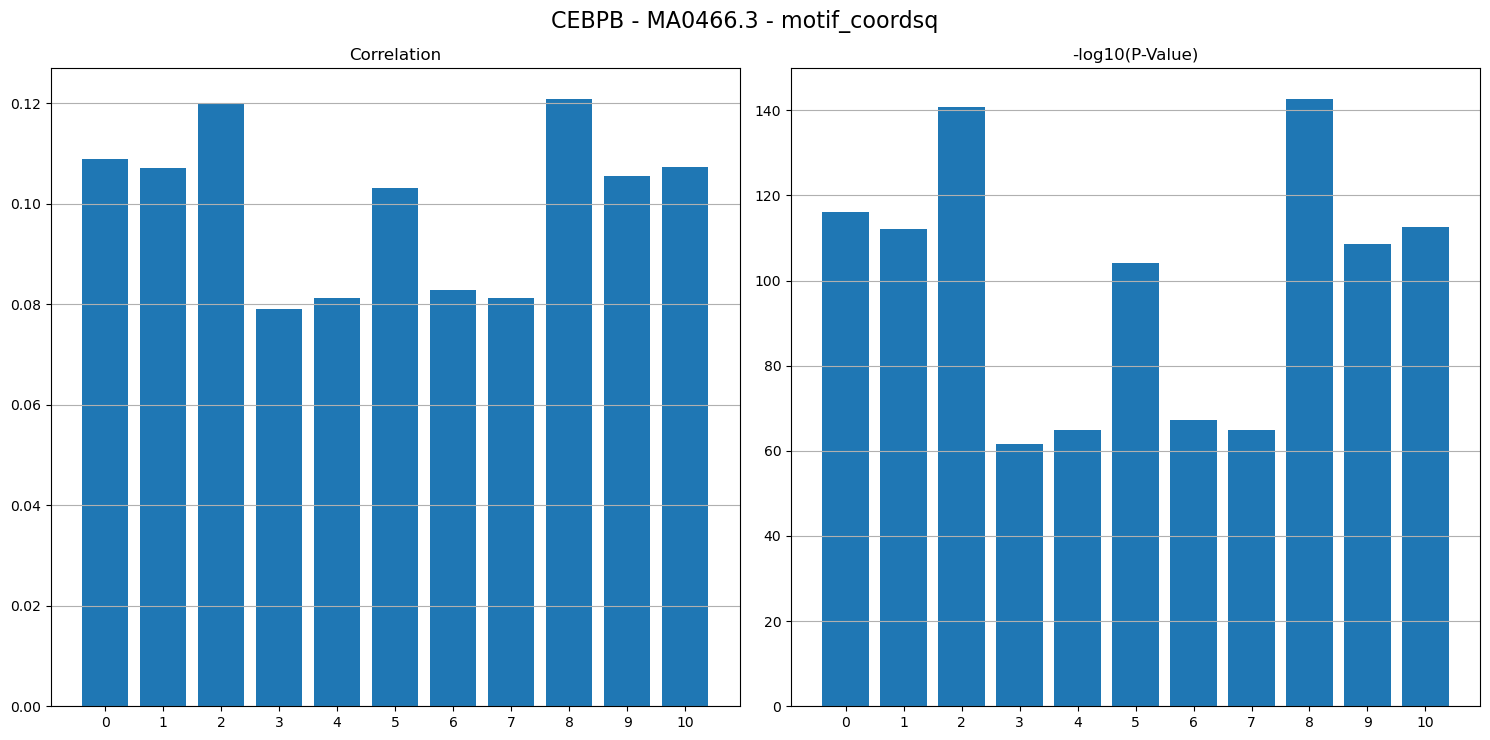

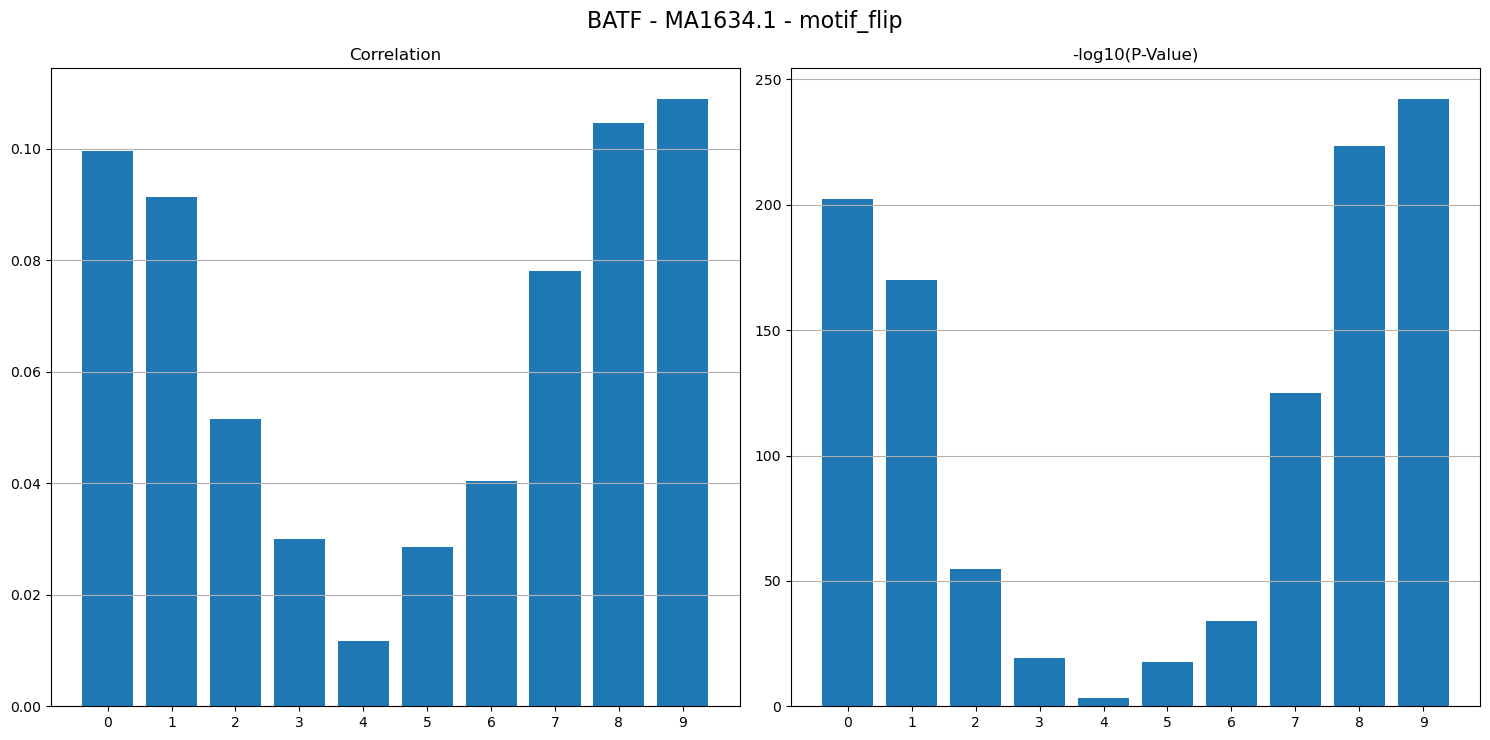

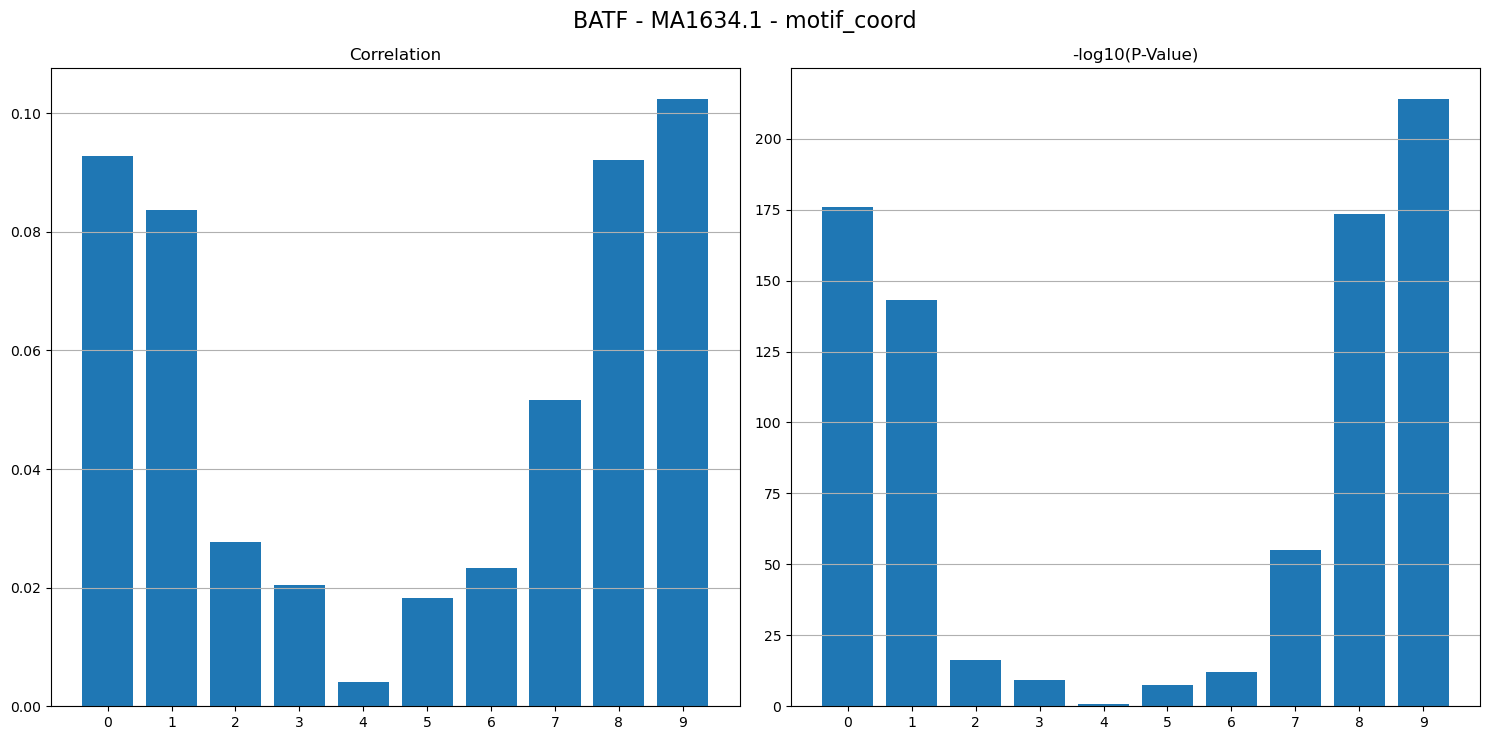

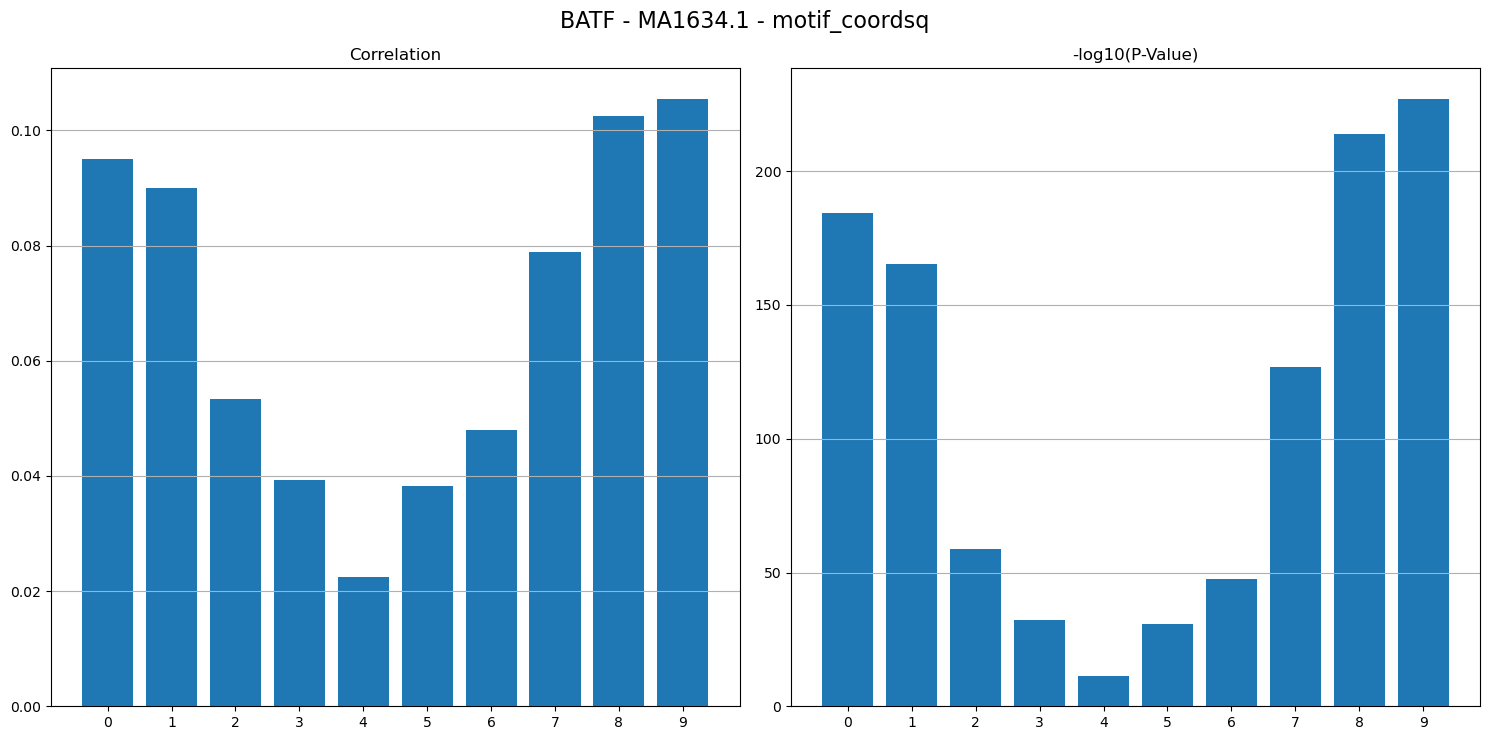

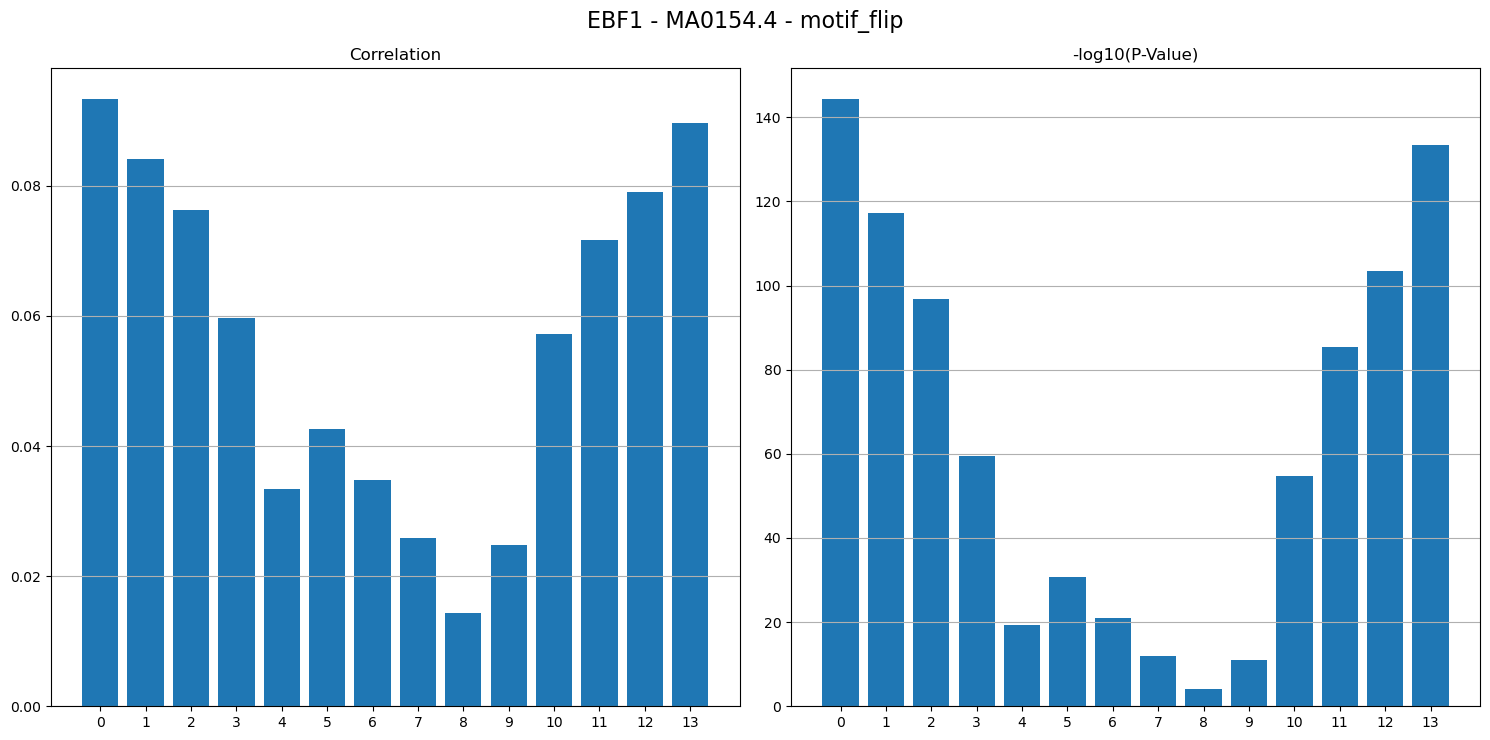

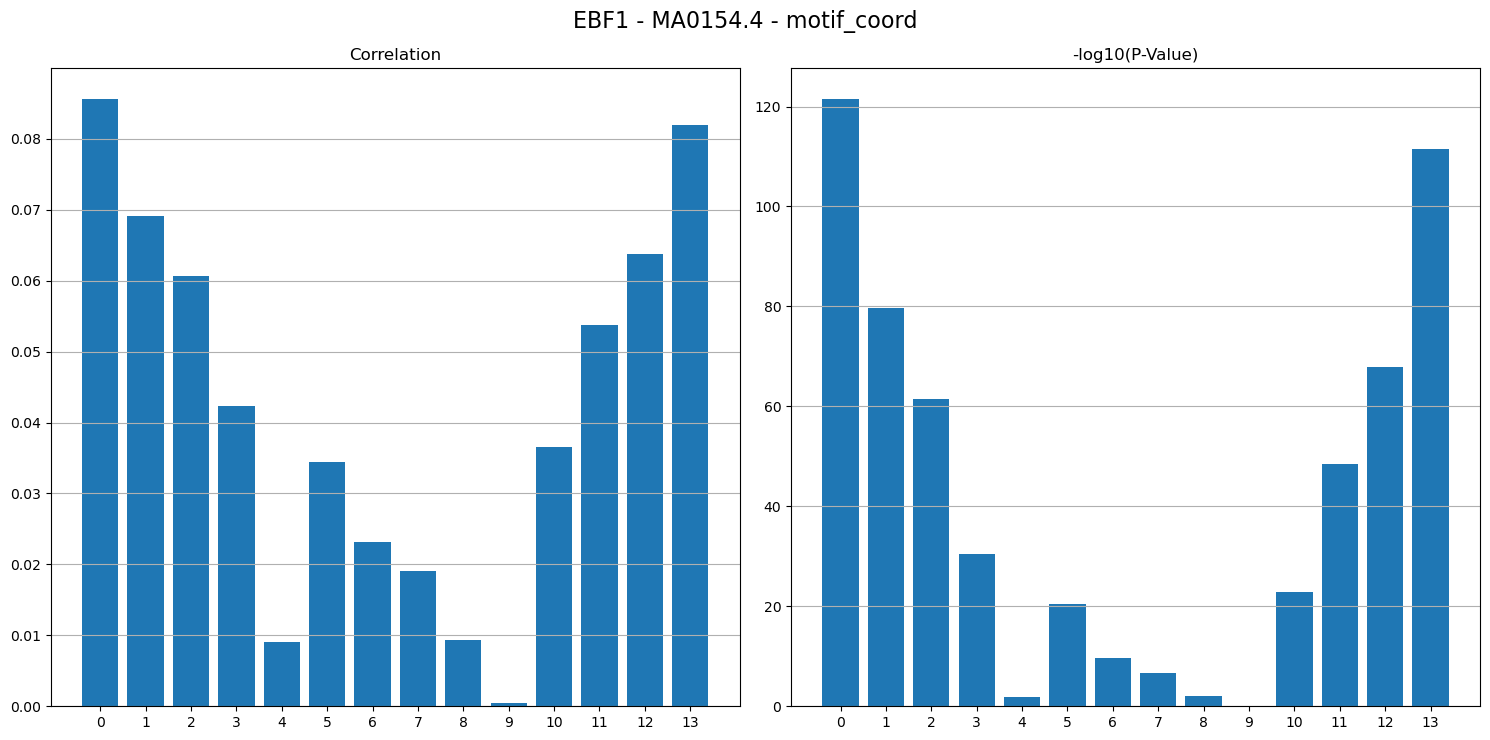

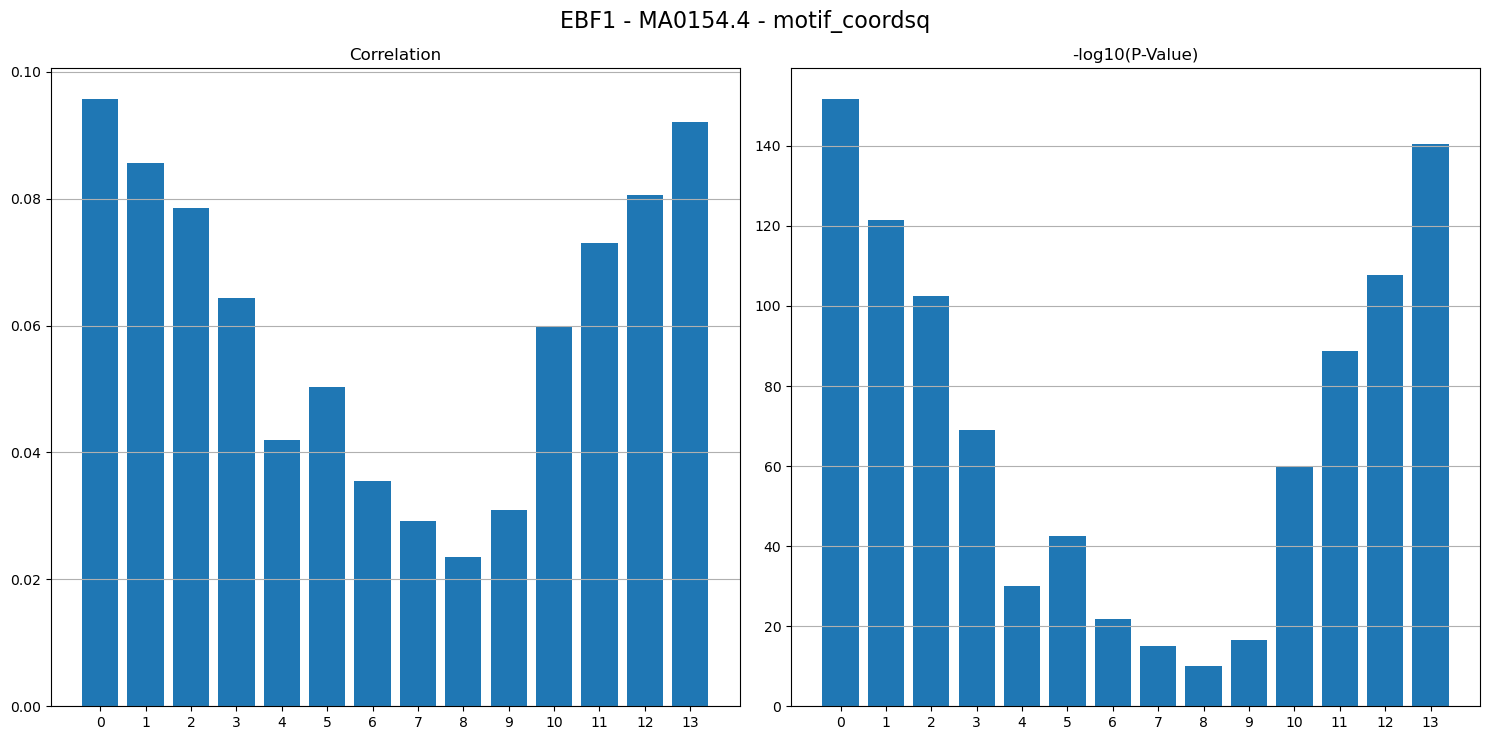

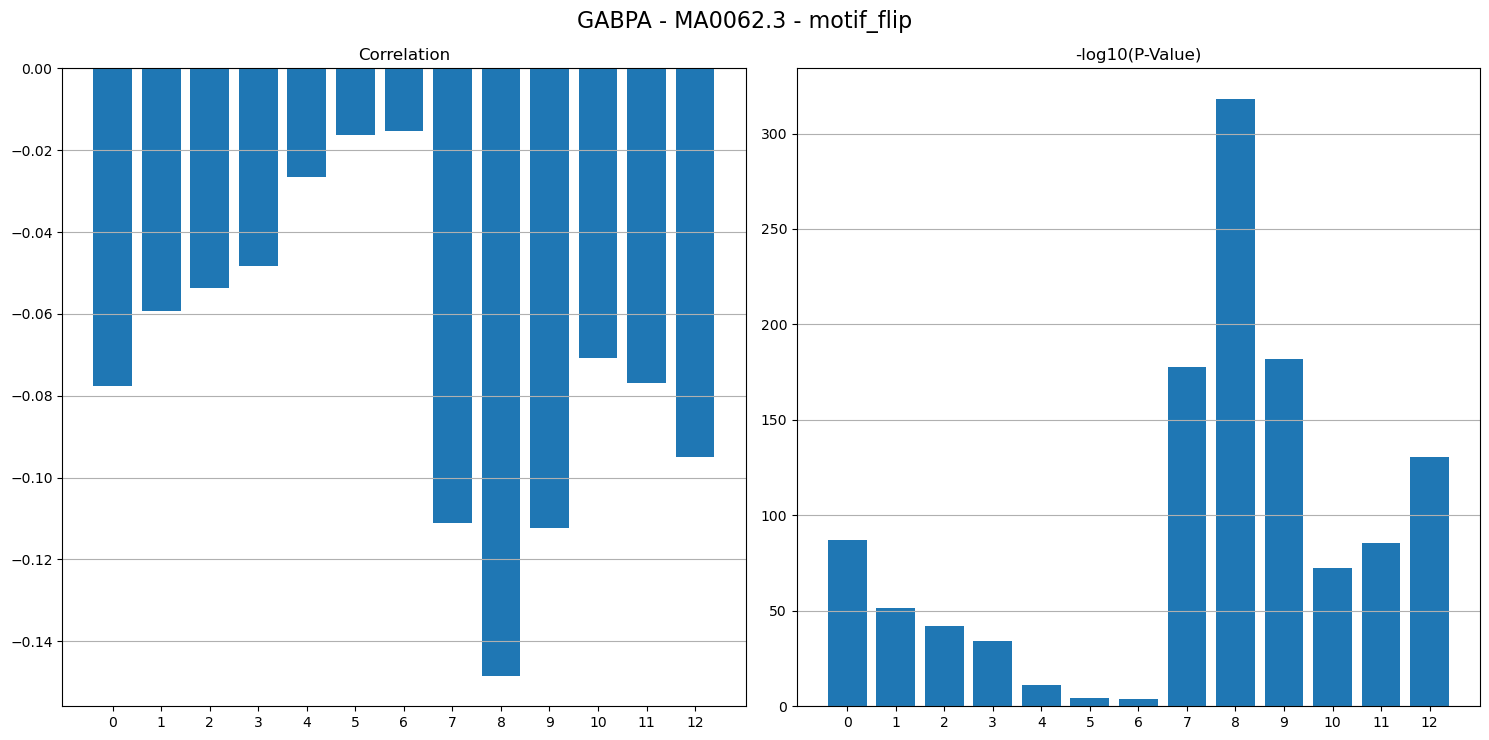

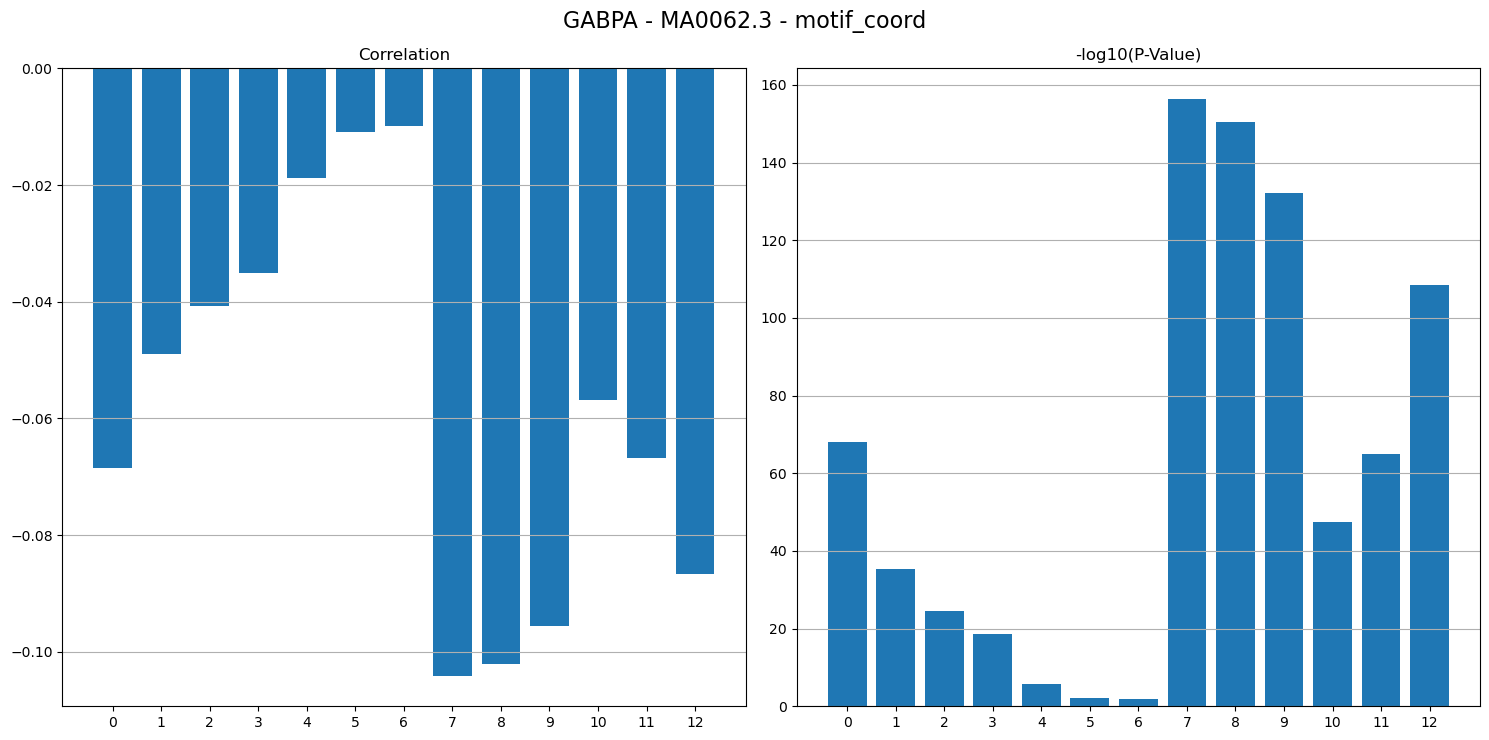

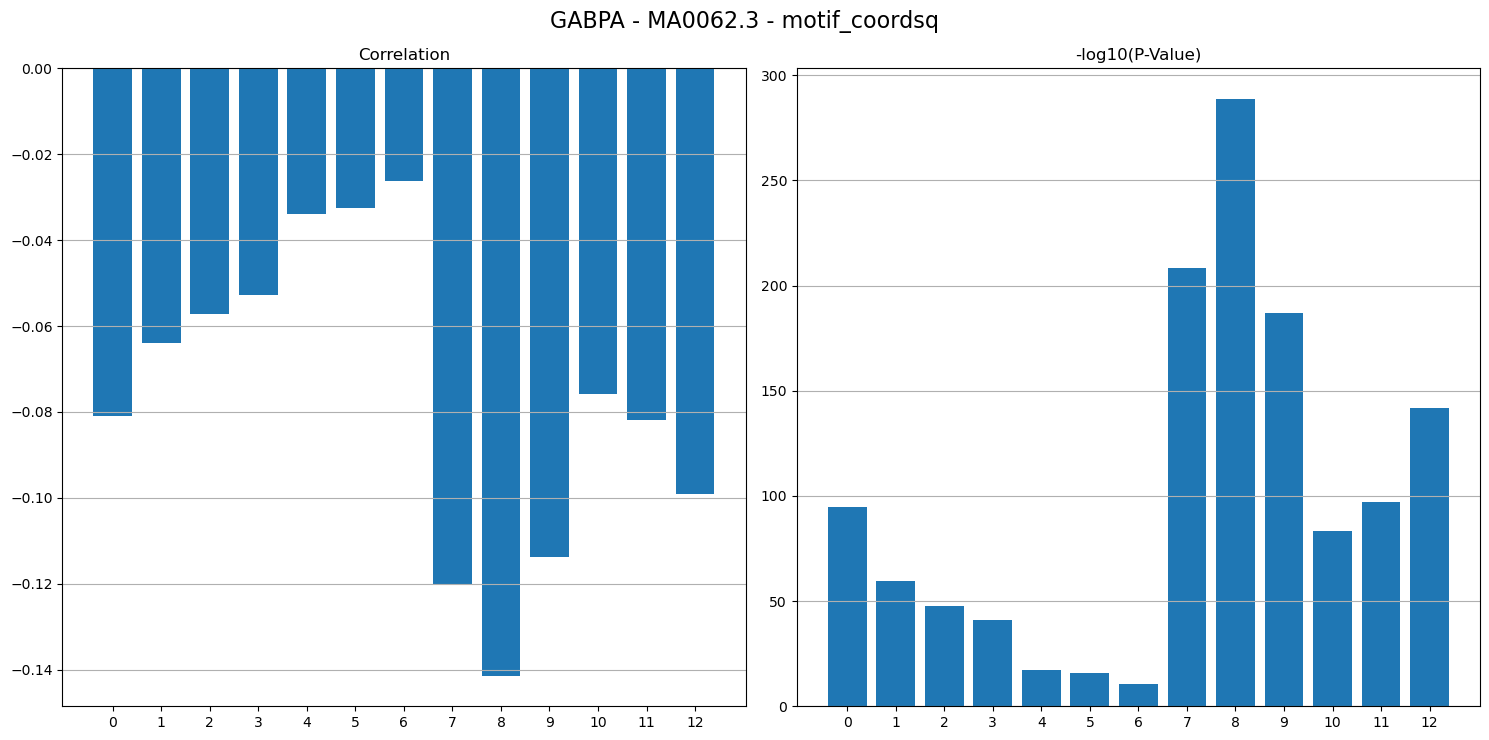

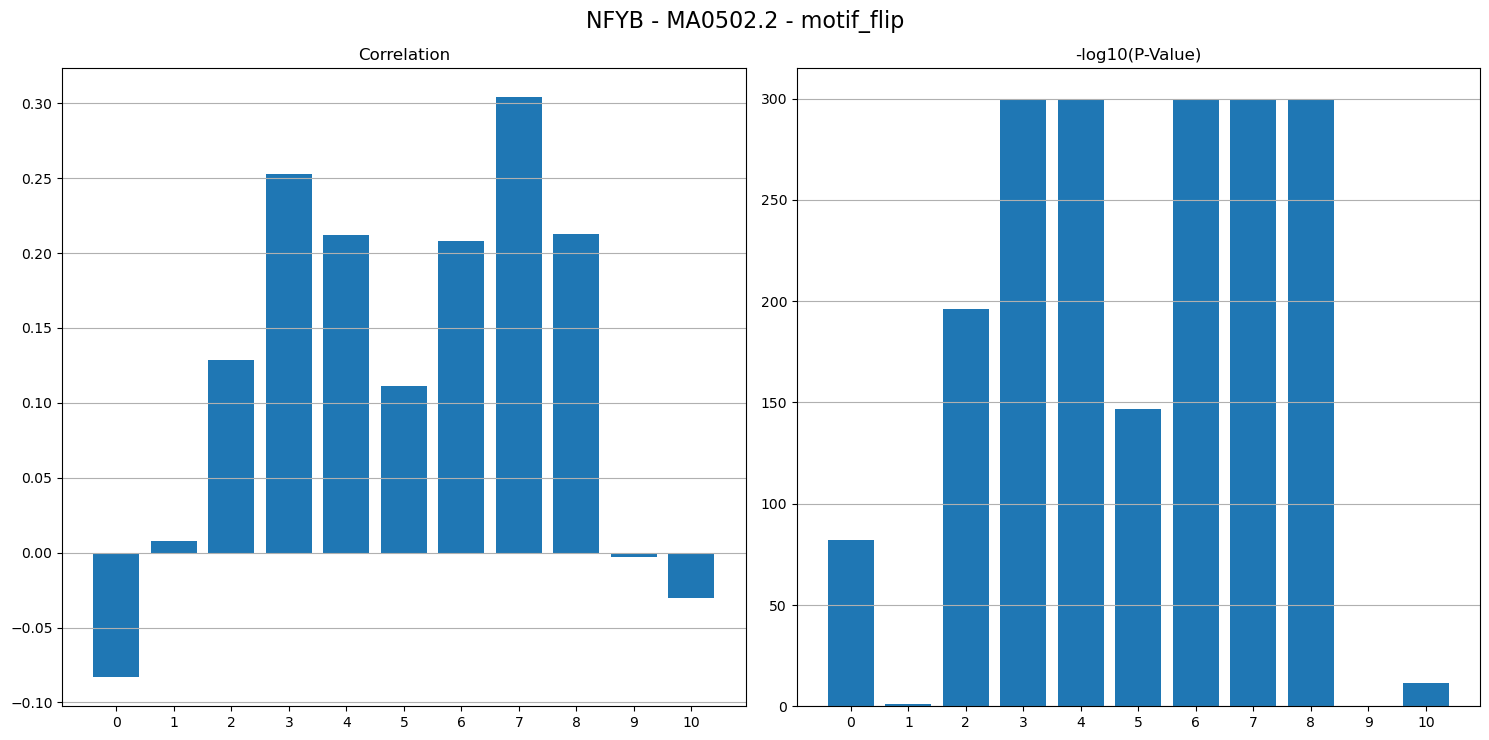

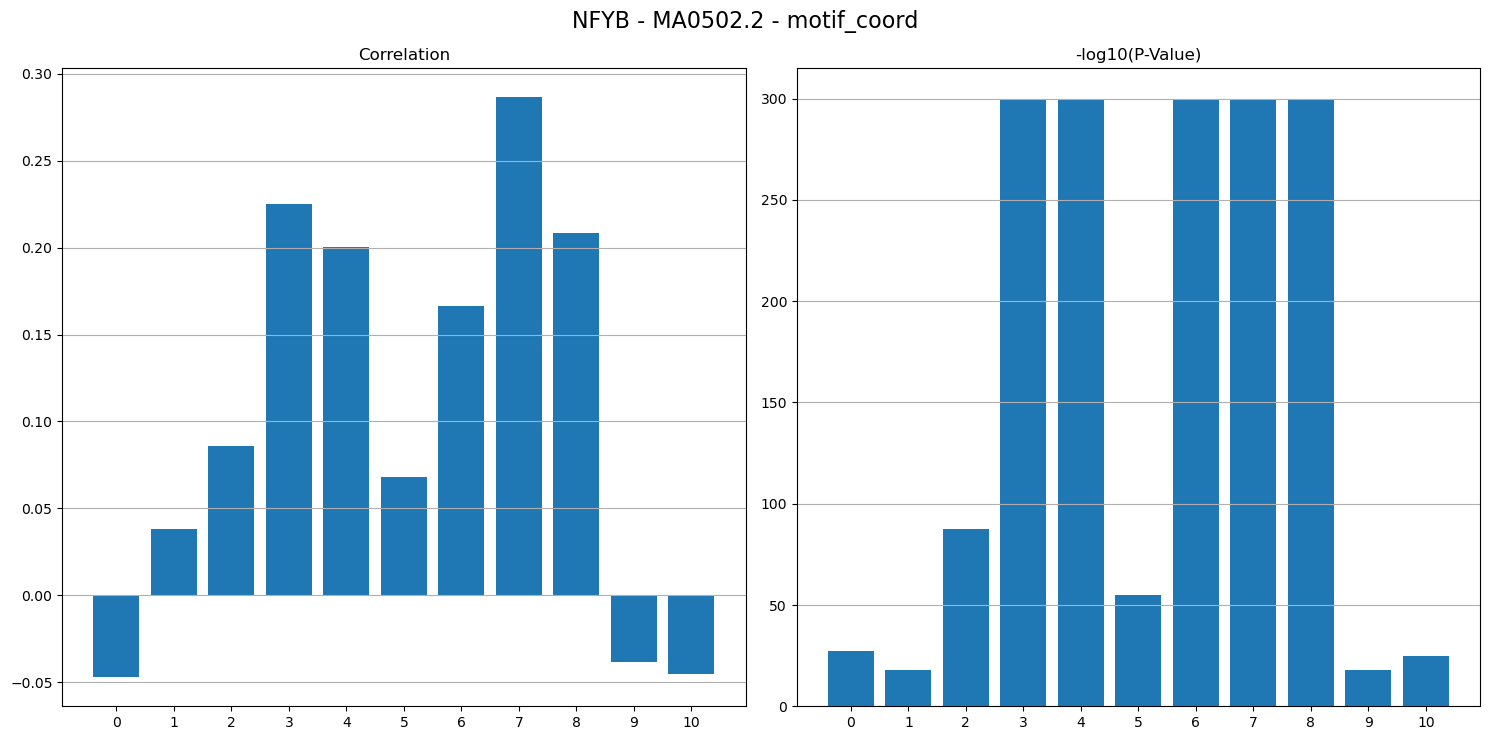

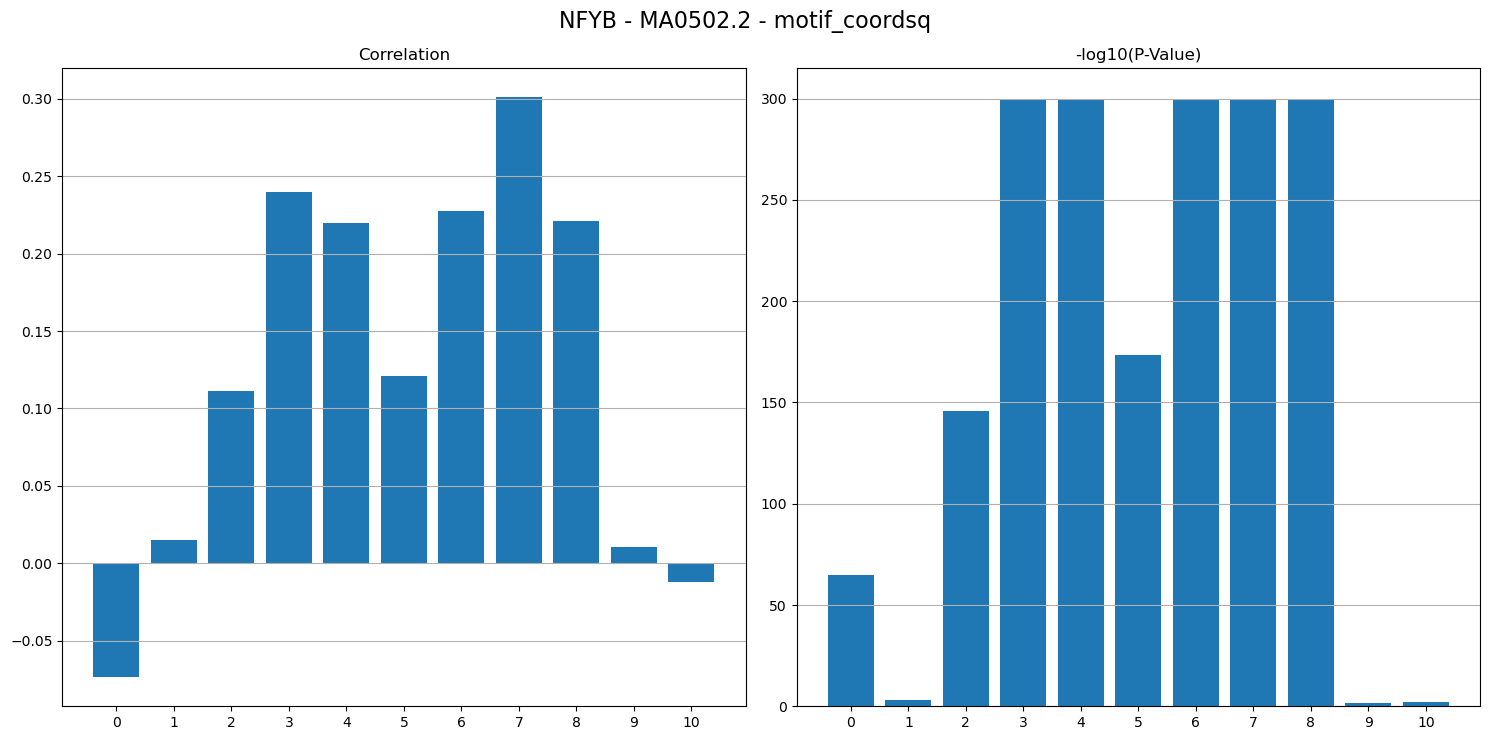

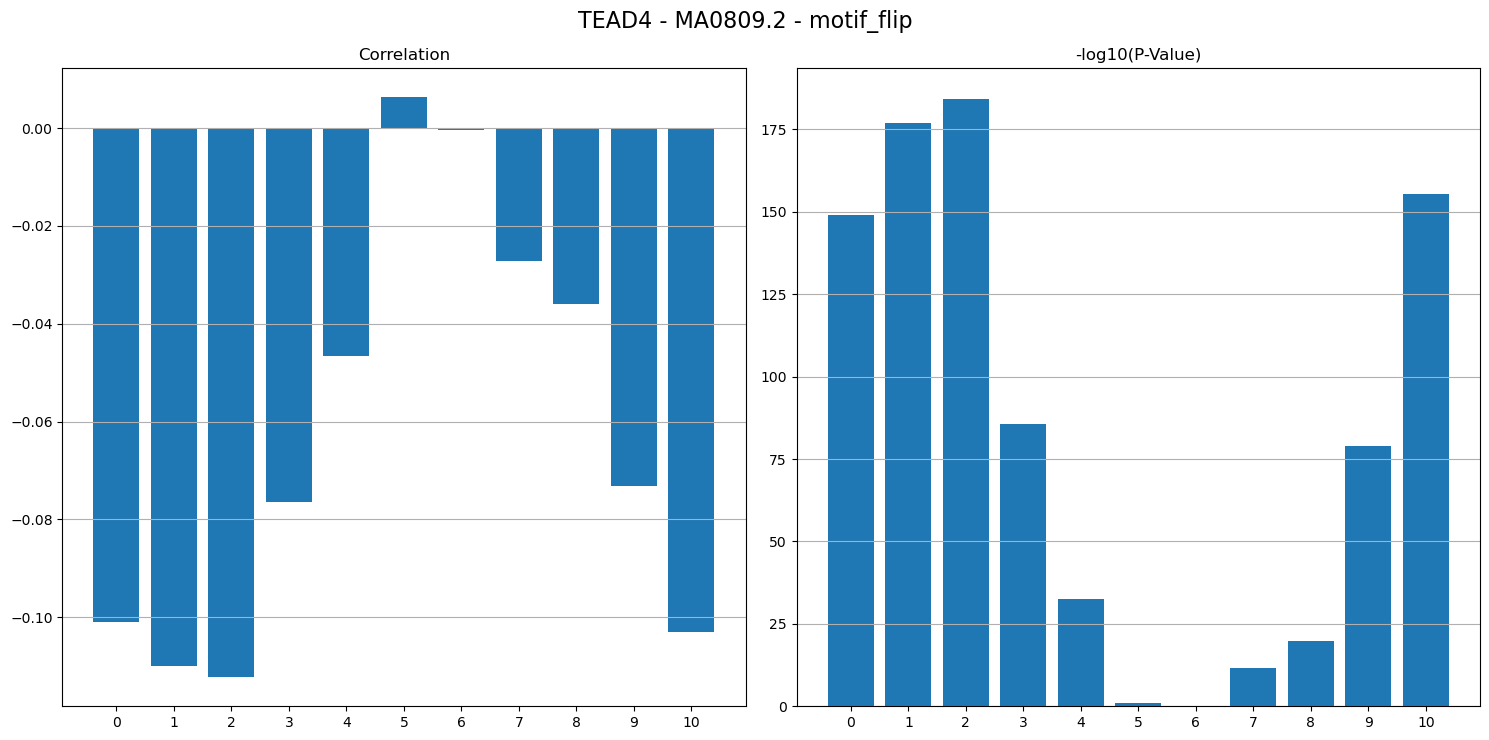

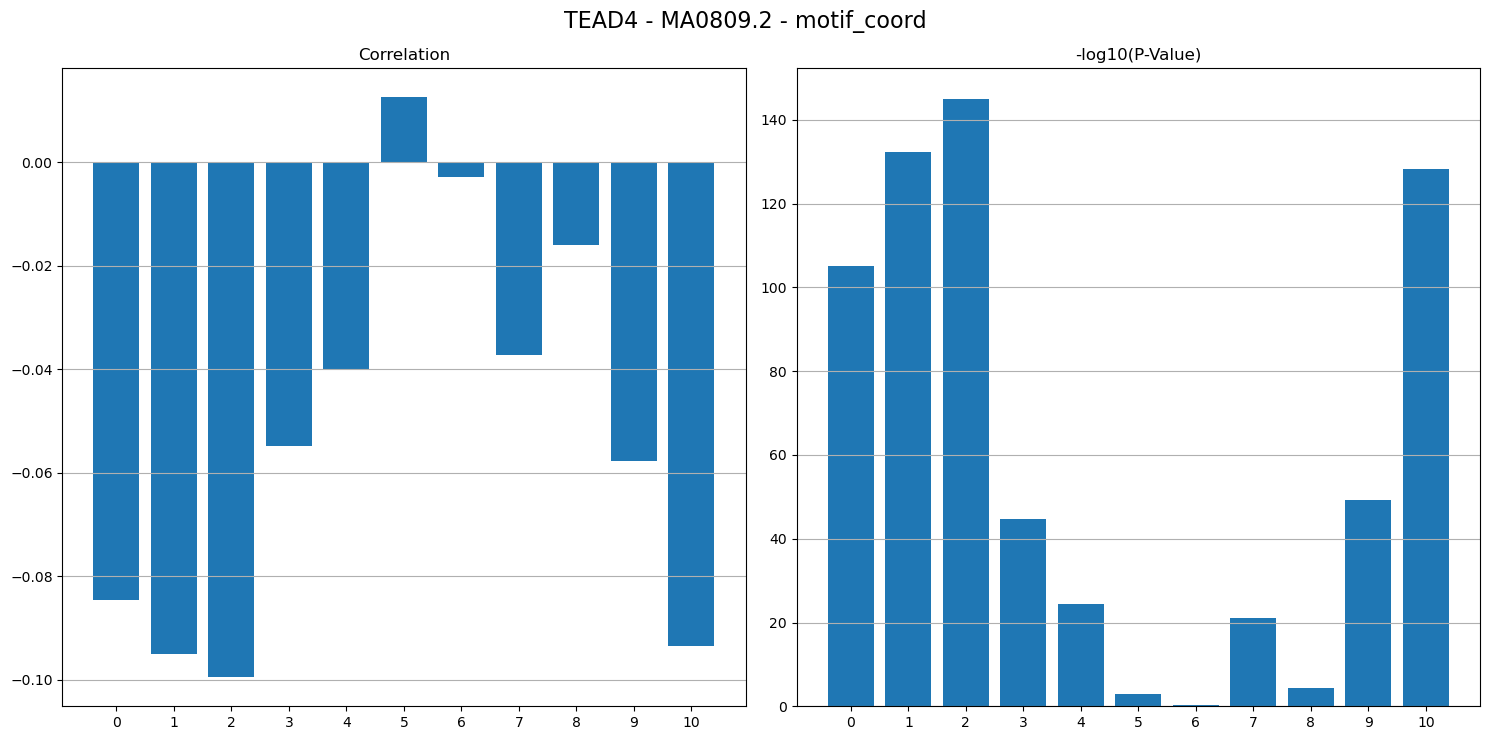

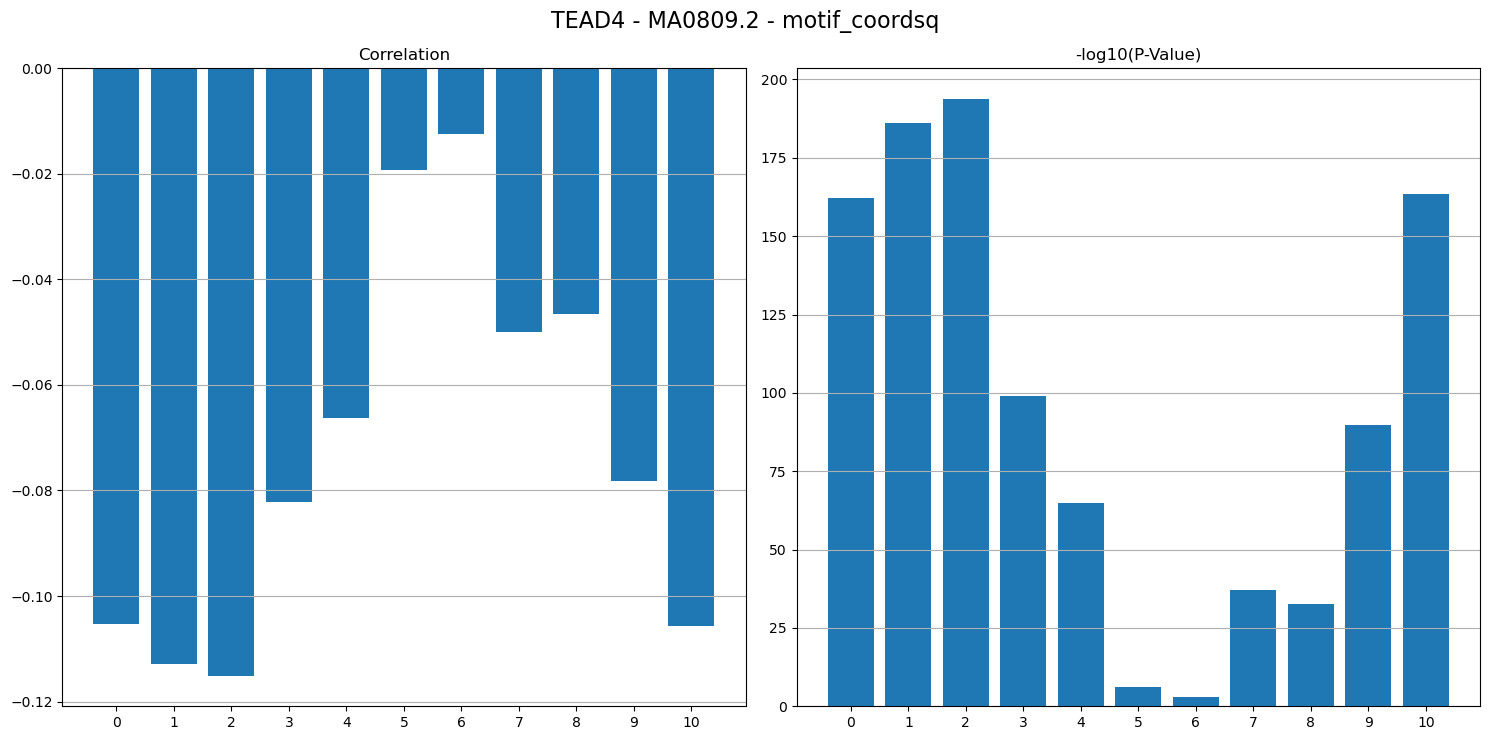

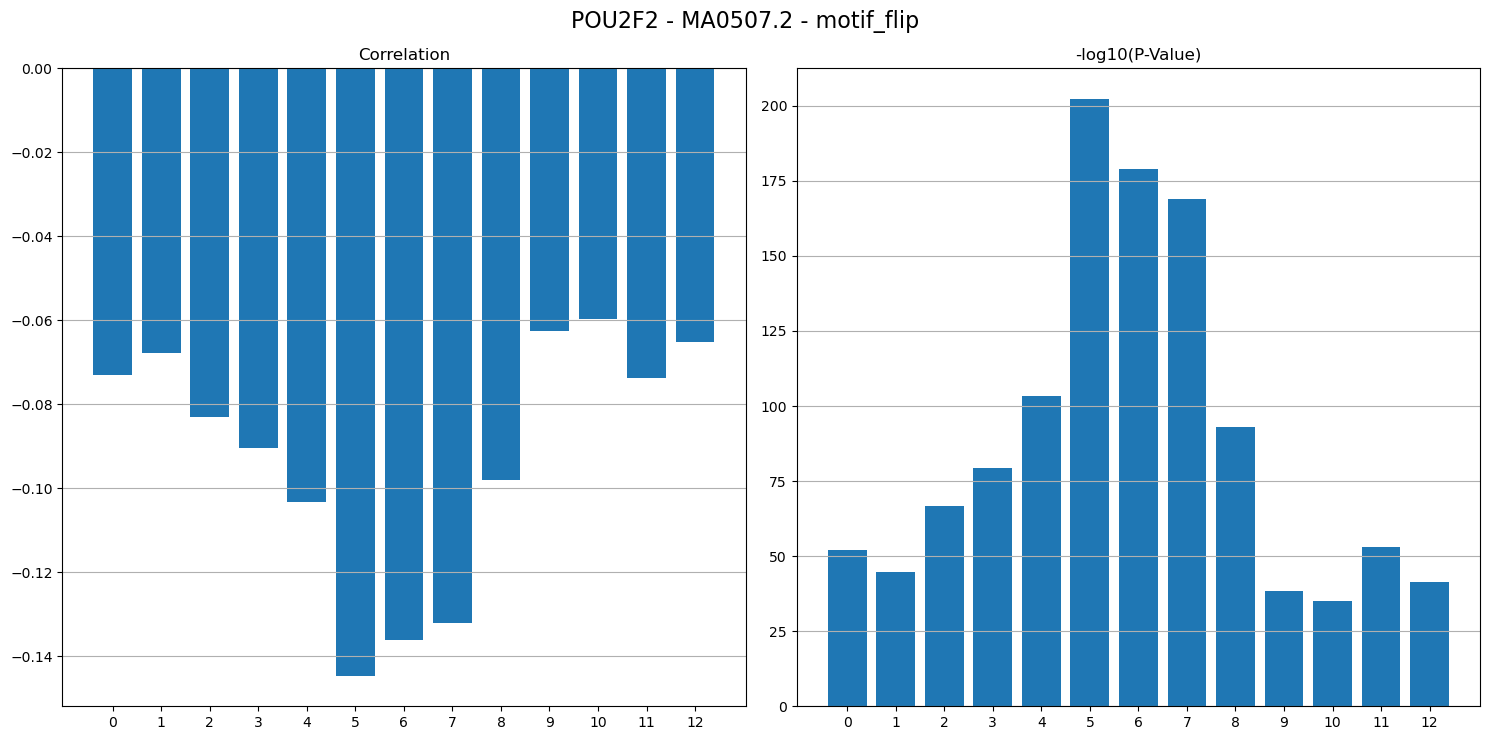

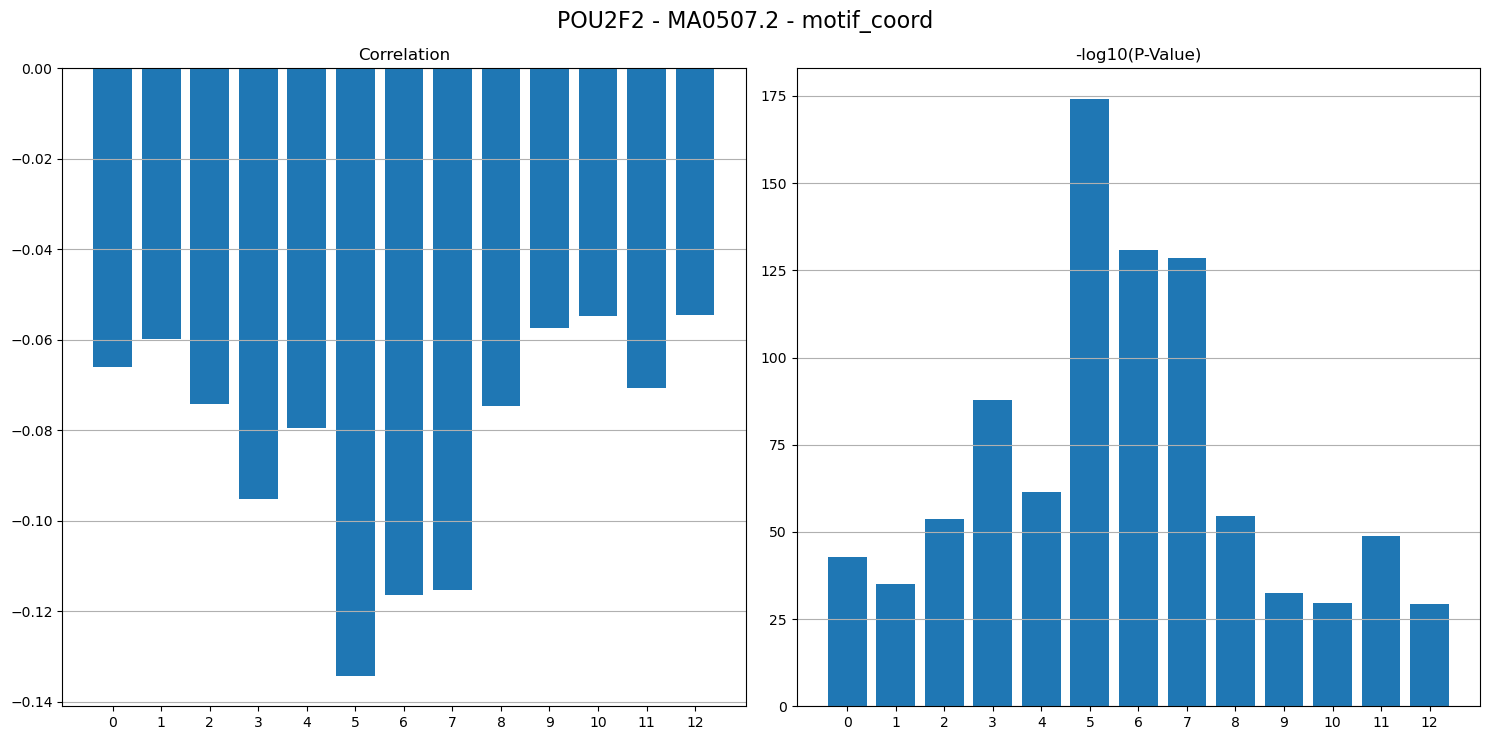

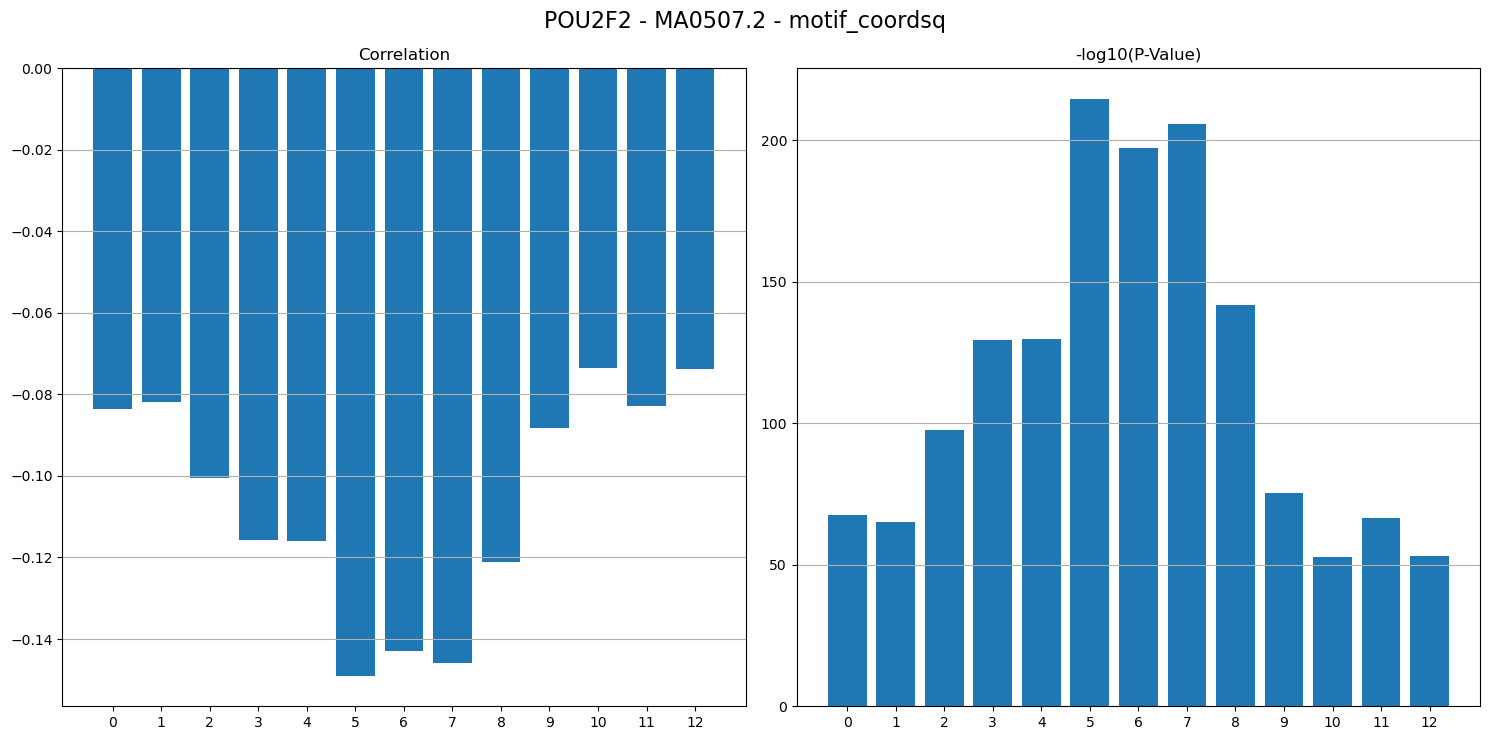

In [12]:
for tf in positional_data.keys():
    for matrix_id in positional_data[tf].keys():
        # only use the matrices if they correspond to values in the correlation_results_df dataframe with *** in the 'Significance' column
        if correlation_results_df.loc[(tf, matrix_id), 'Significance'] == '***':
            length = len(positional_data[tf][matrix_id])
            # make a bargraph for each feature, showing the correlation coefficient and p-value for each position in the motif
            for feature in ['motif_flip', 'motif_coord', 'motif_coordsq']:
                bar_graph = {}
                for i in range(length):
                    bar_graph[i] = {
                        feature: {
                            'correlation': positional_data[tf][matrix_id][i][feature + '_corr'],
                            'p_value': positional_data[tf][matrix_id][i][feature + '_pval'],
                        }
                    }
                positions = list(positional_data[tf][matrix_id].keys())
                correlations = [entry[feature]['correlation'] for entry in bar_graph.values()]
                p_values = [-np.log10(entry[feature]['p_value']) if entry[feature]['p_value'] != 0 else -np.log10(1e-300) for entry in bar_graph.values()]
                
                plt.figure(figsize=(15, 7.5))

                # add a super title
                plt.suptitle(f'{tf} - {matrix_id} - {feature}', fontsize=16)

                plt.subplot(121)
                plt.bar(positions, correlations)
                plt.title('Correlation')
                plt.grid(axis='y')
                plt.xticks(positions, positions)


                plt.subplot(122)
                plt.bar(positions, p_values)
                plt.title('-log10(P-Value)')
                plt.grid(axis='y')
                plt.xticks(positions, positions)

                plt.tight_layout()
                # save the bargraph as a png file in /project2/xinhe/waqaas/DNA-breathing-1/figs/phase4/top_sig_feat/
                #plt.savefig(f'/project2/xinhe/waqaas/DNA-breathing-1/figs/phase4/top_sig_feat/{tf}_{matrix_id}_{feature}.png')
                plt.show()
                

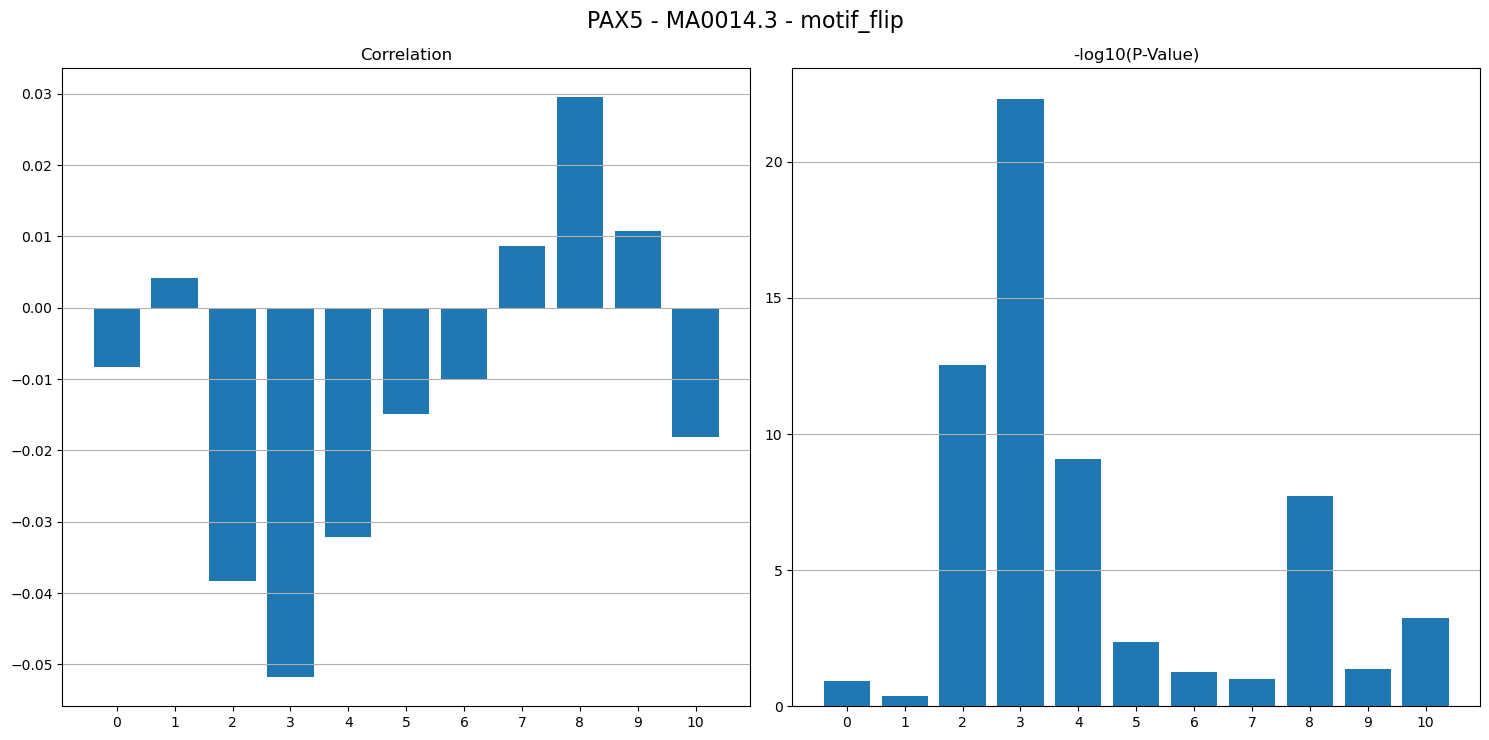

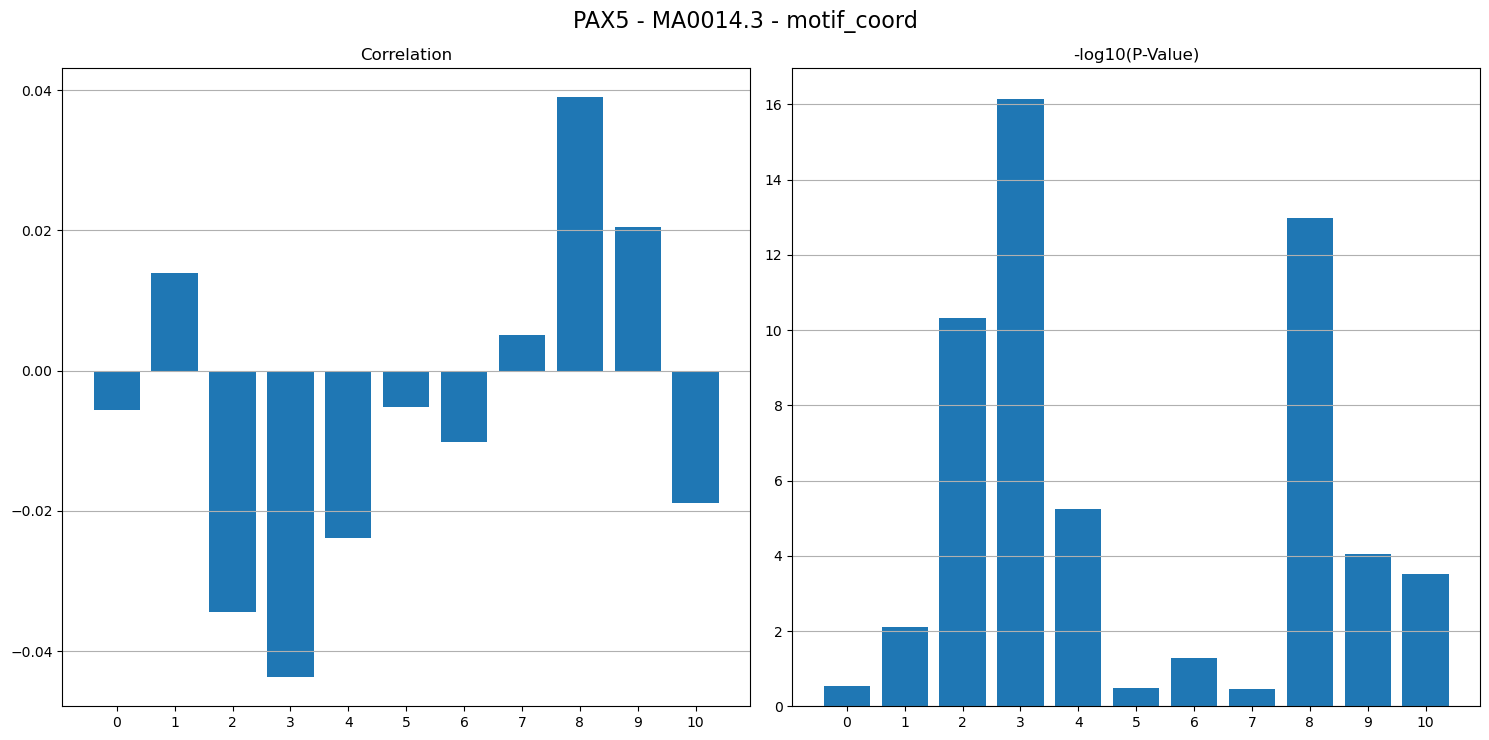

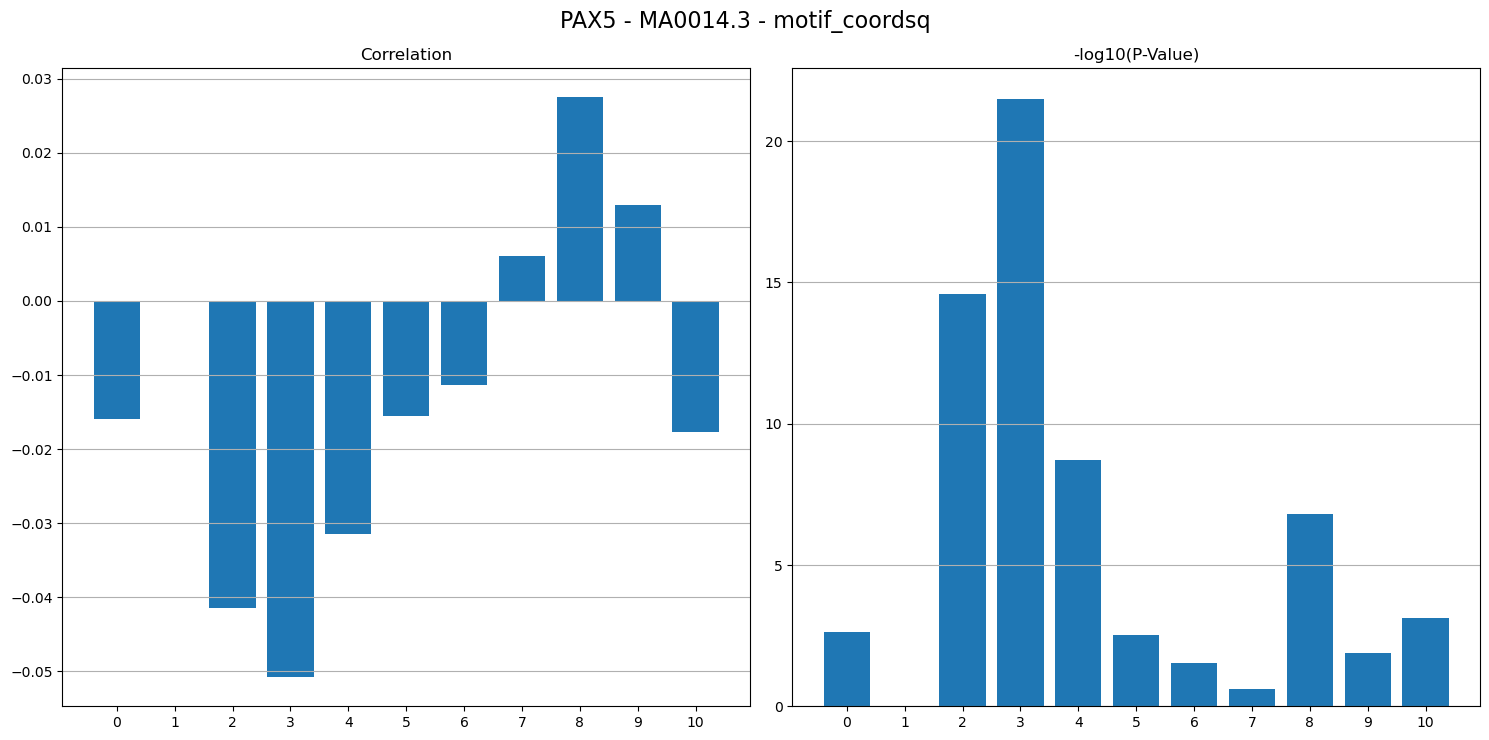

In [13]:
for tf in positional_data.keys():
    for matrix_id in positional_data[tf].keys():
        # only use the matrices if they correspond to values in the correlation_results_df dataframe with *** in the 'Significance' column
        if tf == 'PAX5':
            length = len(positional_data[tf][matrix_id])
            # make a bargraph for each feature, showing the correlation coefficient and p-value for each position in the motif
            for feature in ['motif_flip', 'motif_coord', 'motif_coordsq']:
                bar_graph = {}
                for i in range(length):
                    bar_graph[i] = {
                        feature: {
                            'correlation': positional_data[tf][matrix_id][i][feature + '_corr'],
                            'p_value': positional_data[tf][matrix_id][i][feature + '_pval'],
                        }
                    }
                positions = list(positional_data[tf][matrix_id].keys())
                correlations = [entry[feature]['correlation'] for entry in bar_graph.values()]
                p_values = [-np.log10(entry[feature]['p_value']) if entry[feature]['p_value'] != 0 else -np.log10(1e-300) for entry in bar_graph.values()]
                
                plt.figure(figsize=(15, 7.5))

                # add a super title
                plt.suptitle(f'{tf} - {matrix_id} - {feature}', fontsize=16)

                plt.subplot(121)
                plt.bar(positions, correlations)
                plt.title('Correlation')
                plt.grid(axis='y')
                plt.xticks(positions, positions)


                plt.subplot(122)
                plt.bar(positions, p_values)
                plt.title('-log10(P-Value)')
                plt.grid(axis='y')
                plt.xticks(positions, positions)

                plt.tight_layout()
                # save the bargraph as a png file in /project2/xinhe/waqaas/DNA-breathing-1/figs/phase4/top_sig_feat/
                #plt.savefig(f'/project2/xinhe/waqaas/DNA-breathing-1/figs/phase4/top_sig_feat/{tf}_{matrix_id}_{feature}.png')
                plt.show()
                